# Intro Call Scoring Model - Data Storytelling

Goals of the project:
    
    1) Determine if correlations between key sales indicators (account level demographics, lead characteritics, etc) and qualification/deal oppty exist.
    
    2) Is there a statistically significant difference between qualified and disqualified intro calls in regards to information given?
    
    3) Create machine learning model that allows us to predict whether an introcall will be qualified, whether opportunity will result, and the value of the resulting opportunity. Look at important features as well.

In [1]:
import psycopg2
from sqlalchemy.engine import url as sa_url
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker

import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style(style='white')

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)



In [2]:
#function to clean dates
def clean_dates(df, oldColName, newColName, timedatepattern):
    """This will take a dataframe, a number of column names & create new columns of datetime objects"""
    emptyDateFrame = []
    colPosition = len(df.columns)
    for date in df[oldColName]:
        if date != None:
                if pd.isna(date):
                        emptyDateFrame.append(np.nan)
                else:        
                        if isinstance(date, str):
                                emptyDateFrame.append(datetime.datetime.strptime(date, timedatepattern))
                        else:
                                emptyDateFrame.append(datetime.datetime.strptime(str(date), timedatepattern))
        else:
            emptyDateFrame.append(None)
    df.insert(colPosition, newColName, emptyDateFrame)
    del df[oldColName]
    return df

In [3]:
#function to rempa values based on provded dicts
def clean_map(df, dictToMap, oldColName):
    """This will take a dataframe, 
    a number of column names & 
    create new columns of datetime objects"""
    newColName = oldColName + "_map"
    df[newColName] = df[oldColName].map(dictToMap) 
    del df[oldColName]
    return df


engine = create_engine('redshift+psycopg2://username@host.amazonaws.com:5439/database')

In [4]:
#Create the database connection to the company database
db_connect_url = sa_url.URL(
            drivername='postgresql+psycopg2',
            username='',
            password='',
            host='',
            port='',
            database=''
)
engine = create_engine(db_connect_url)
con = engine.connect()


#Ensure connection to the right schemas within the tables within the database
session = sessionmaker()
session.configure(bind=engine)
s = session()
SetPath = "SET search_path TO %s" % 'ods'
s.execute(SetPath)

In [5]:
# Query vis SQL Aclhemy th Leads and Introcalls tables to create the lead scoring table

leads_query = "Select * from sf_lead"
rs = s.execute(leads_query)
leads_raw = pd.DataFrame(rs.fetchall())
leads_raw.columns = rs.keys()


pd.DataFrame(leads_raw.head(50)).to_csv('leads_sample.csv')
leads_raw.to_csv('leads_full_data.csv')
#leads_raw = pd.read_csv('leads_full_data.csv')

In [6]:
#Intro Calls
intro_calls_query = "Select * from sf_intro_call__c"
rs = s.execute(intro_calls_query)
intro_calls_raw = pd.DataFrame(rs.fetchall())
intro_calls_raw.columns = rs.keys()

pd.DataFrame(intro_calls_raw.head(50)).to_csv('intro_calls_sample.csv')
intro_calls_raw.to_csv('intro_calls_full_data.csv')
#intro_calls_raw = pd.read_csv('intro_calls_full_data.csv')

In [7]:
s.close()
con.close()

# Data Description

In [8]:
# Lead Data
print("___________________________________Summary on Leads Object___________________________________")
print("Leads Raw Info:", leads_raw.info())
print("Leads Raw Count:", leads_raw.count())
lead_raw_list = list(leads_raw.columns)

#Intro Call Data
print("___________________________________Summary on Intro Calls Object___________________________________")
print("Intro Call Raw Info:",intro_calls_raw.info())
print("Intro Call Raw Count:",intro_calls_raw.count())
intro_calls_raw_list = list(intro_calls_raw.columns)

___________________________________Summary on Leads Object___________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 491538 entries, 0 to 491537
Columns: 107 entries, id to clearbit_employees__c
dtypes: bool(17), datetime64[ns](1), float64(5), int64(1), object(83)
memory usage: 345.5+ MB
Leads Raw Info: None
Leads Raw Count: id                                    491538
isdeleted                             491538
masterrecordid                            26
lastname                              491538
firstname                             380795
salutation                              6077
name                                  491538
title                                 301034
company                               491538
street                                 67787
city                                  425686
state                                 249676
postalcode                             61492
country                               443414
email           

In [9]:
# Fields to Use for master data set
lead_fields_masterDataSet =['email','firstname','lastname','title','customer_type__c','company','street','city','state','country','linkedin_page__c','traffic_channels__c','marketing_channel_campaign_name__c','landing_page__c','landing_page_url__c','google_campaign__c','leadsource','converteddate','status_reason__c','status','id','convertedaccountid','convertedcontactid','convertedopportunityid','ownerid','createdbyid','createddate','duplicate_lead__c','isconverted','isdeleted','pitch__c','infer3__infer_score__c','total_calls__c','total_emails__c','users_amount__c','marketing_camp_id__c','marketing_channel_ad_id__c','of_employees_category__c']
intro_call_fields_masterDataSet = ['id','lead_name__c','related_account__c','related_opportunity__c','ownerid','contact__c','assigned_to__c','assigned_to_role__c','name','createdbyid','createddate','isdeleted','meeting_status__c','lead_status__c','qualification_date__c','qualified_without_opp_reason_other__c','qualified_without_opportunity_reason__c','rejected_other_reason__c','rejected_reason__c','rescheduled__c','rescheduled_from_intro_call__c','no_show_other_reason__c','no_show_reason__c','additional_user_information__c','meeting_comments__c','sales_comments__c','use_cases_pains__c','customer_employee_facing__c','decision_maker_picklist__c','double_dipper__c','project_due_quarter_fiscal__c','product__c','product_s__c','application_type__c','new_existing_customer__c','intro_call_source_marketing_outbound__c','recordtypeid','created_day_of_the_week__c']

## Data Joining

In [10]:
# Isolate out the desired data to combine
leads_join_masterDataSet = leads_raw[lead_fields_masterDataSet]
intro_call_join_masterDataSet = intro_calls_raw[intro_call_fields_masterDataSet]


In [11]:
# Rename Columns
leads_join_masterDataSet.columns = ['email___Lead_PersonalInformation','firstname___Lead_PersonalInformation','lastname___Lead_PersonalInformation','title___Lead_PersonalInformation','customerType___Lead_LeadCompanyInformation','company___Lead_LeadCompanyInformation','street___Lead_LeadCompanyInformation','city___Lead_LeadCompanyInformation','state___Lead_LeadCompanyInformation','country___Lead_LeadCompanyInformation','linkedinPage___Lead_MarketingInformation','trafficChannel___Lead_MarketingInformation','mktChannelcampaign___Lead_MarketingInformation','landingPage___Lead_MarketingInformation','landingPageUrl___Lead_MarketingInformation','googleCampaign___Lead_MarketingInformation','leadsource___Lead_MarketingInformation','converteddate___Lead_ConversionInformation','statusReason___Lead_ConversionInformation','status___Lead_ConversionInformation','PK_LeadID___Lead_ImportantJoinKey','FK_LeadtoAccount___Lead_ImportantJoinKey','FK_LeadtoContact___Lead_ImportantJoinKey','FK_LeadtoOpportunity___Lead_ImportantJoinKey','FK_LeadtoUser___Lead_ImportantJoinKey','createdbyid___Lead_ImportantSystemInfo','createddate___Lead_ImportantSystemInfo','duplicateLead___Lead_ImportantSystemInfo','isconverted___Lead_ImportantSystemInfo','isdeleted___Lead_ImportantSystemInfo','pitch___Lead_AddedInfo','inferScore___Lead_AddedInfo','totalCalls___Lead_AddedInfo','totalEMails___Lead_AddedInfo','usersAmount___Lead_AddedInfo','marketingCampaignID___Lead_AddedInfo','marketingChannelAdID___Lead_AddedInfo','employeeCategory___Lead_AddedInfo']
intro_call_join_masterDataSet.columns = ['PK_IntroCall_ID___IntroCall_ImportantIDInfo','FK_IntroCalltoLead___IntroCall_ImportantJoinKey','FK_IntroCalltoAccount___IntroCall_ImportantJoinKey','FK_IntroCalltoOppty___IntroCall_ImportantJoinKey','FK_IntroCalltoUser___IntroCall_ImportantJoinKey','FK_IntroCalltoUser___IntroCall_ImportantJoinKey','FK_IntroCalltoContacts___IntroCall_ImportantJoinKey','assignedToRole___IntroCall_OtherInfo','name___IntroCall_OtherInfo','createdbyid___IntroCall_ImportantSystemInfo','createddate___IntroCall_ImportantSystemInfo','isdeleted___IntroCall_ImportantSystemInfo','Target___IntroCall_Outcome','leadStatus___IntroCall_Outcome','qualDate___IntroCall_Outcome','qualWithoutOppReason1___IntroCall_Outcome','qualWithoutOppReason2___IntroCall_Outcome','rejectedOtherReason___IntroCall_Outcome','rejectedReason___IntroCall_Outcome','rescheduled___IntroCall_Outcome','rescheduledFromIntroCall___IntroCall_Outcome','noShowReason2___IntroCall_Outcome','noShowReason1___IntroCall_Outcome','addUserInfo___IntroCall_MeetingDetails','meetingComments___IntroCall_MeetingDetails','salesComments___IntroCall_MeetingDetails','useCases___IntroCall_MeetingDetails','customerOrEmployee___IntroCall_MeetingDetails','decisionMaker___IntroCall_MeetingDetails','doubleDipper___IntroCall_MeetingDetails','projectDueQ___IntroCall_MeetingDetails','produce1___IntroCall_MeetingDetails','product2___IntroCall_MeetingDetails','appType___IntroCall_MeetingDetails','newOrExistingCustomer___IntroCall_LeadInformation','introCallMktSource___IntroCall_LeadInformation','recordtypeid___IntroCall_LeadInformation','createdDayOFWeek___IntroCall_AddedInfo']

In [12]:
# Left Join Lead to Intro Call via Intro Call's lead_name_c and Lead's convertedopportunityid

masterDataSet = pd.merge(intro_call_join_masterDataSet,leads_join_masterDataSet, how='left', left_on=['FK_IntroCalltoLead___IntroCall_ImportantJoinKey'],right_on=['PK_LeadID___Lead_ImportantJoinKey'])


In [13]:
#Making a copy - original safe keeping
masterDataSetCopy = masterDataSet.copy()

masterDataSetCopy.to_csv('masterDataSet_LeadsIntroCalls_copy.csv')

In [14]:
#DateTime Cleaning
#masterDataSetCopy_dateTimeTest = clean_dates(masterDataSetCopy, 'qualDate___IntroCall_Outcome','qualDate___IntroCall_Outcome_clean','%Y-%m-%d')
masterDataSetCopy_dateTimeTest = clean_dates(masterDataSetCopy, 'converteddate___Lead_ConversionInformation', 'converteddate___Lead_ConversionInformation_clean','%Y-%m-%d')

#Because of the odd formatting that occasionally comes out of Salesforce we need to take the first 10 characters before the 'tz' denotation
masterDataSetCopy_dateTimeTest['createddate___Lead_ImportantSystemInfo'] = masterDataSetCopy_dateTimeTest['createddate___Lead_ImportantSystemInfo'].str[:10]
masterDataSetCopy_dateTimeTest['createddate___IntroCall_ImportantSystemInfo'] = masterDataSetCopy_dateTimeTest['createddate___IntroCall_ImportantSystemInfo'].str[:10]

masterDataSetCopy_dateTimeTest = clean_dates(masterDataSetCopy_dateTimeTest, 'createddate___Lead_ImportantSystemInfo', 'createddate___Lead_ImportantSystemInfo_clean','%Y-%m-%d')
masterDataSetCopy_dateTimeTest = clean_dates(masterDataSetCopy_dateTimeTest, 'createddate___IntroCall_ImportantSystemInfo', 'createddate___IntroCall_ImportantSystemInfo_clean','%Y-%m-%d')


In [15]:
# Time Deltas

masterDataSetCopy_dateTimeTest['introCallCreated_leadCreated_delta'] = (masterDataSetCopy_dateTimeTest['createddate___IntroCall_ImportantSystemInfo_clean'] - masterDataSetCopy_dateTimeTest['createddate___Lead_ImportantSystemInfo_clean']).dt.days
#masterDataSetCopy_dateTimeTest['qualDate_introCallDate_delta'] = (masterDataSetCopy_dateTimeTest['qualDate___IntroCall_Outcome_clean'] - masterDataSetCopy_dateTimeTest['createddate___IntroCall_ImportantSystemInfo_clean']).dt.days


In [16]:
#use dictionaries to regroup values

Target___IntroCall_Outcome_dict={"Attributed":1,"Cancelled":0,"No Show":0,"Qualified":1,"Rejected":0,"Rescheduling":-1,"Scheduled":-1}
rejectedReason___IntroCall_Outcome_dict={"Company Too Small":"Wrong_Demographic","Does Not See Benefit of WalkMe":"Not_Interested","Existing Opportunity":"Duplicate","No Budget/Price Too High":"Price_Too_High","No Commercial influence":"Not_Right_Person","Not A Use Case Fit":"Not_Interested","Not Decision Maker":"Not_Right_Person","Other (please specify)":"Other","Project Fully Outsourced":"Other","Startup - Too Expensive":"Price_Too_High","Too Few Users":"Wrong_Demographic","Wrong Source Version":"Other","Wrong Timing":"Not_Interested","__":"Other"}
status___Lead_ConversionInformation_dict={"Cancelled":0,"Conference Rejuvenated":-1,"Contacted":0,"Converted":1,"Engaged":-1,"Finished Sequence":-1,"Junk":0,"Moved to SE":-1,"No Show":0,"No longer with company":0,"Not Relevant":0,"Nurture":-1,"Nurture (Outbound)":-1,"Open":-1,"Prospecting":-1,"Qualified":1,"Rejected":0,"Rejuvenated":-1,"SBC - Rejected":0,"SE Qualified":1,"SE Rejected":0,"Scheduled":-1,"Sent to Partner":0,"Unqualified":0}
trafficChannel___Lead_MarketingInformation_dict={"Organic SEO":"SEO","Affiliate":"Affiliate","Banner":"Other","Bing":"Bing","Biz Dev":"Other","BizoLi":"Other","Brand":"Brand","Bulk upload - R&D's bug":"Other","Conference Emails":"Email","Conferences":"Event/Conference","Conferences Lead Swaps":"Event/Conference","Customer Engagement Event":"Event/Conference","Email Nurturing":"Email","Email Nurturing Conferences":"Email","EmailMarketing":"Email","EmailNurturing":"Email","External":"Event/Conference","External Conferences":"Event/Conference","Facebook":"Facebook","FootPrints":"Other","LinkedIn":"LinkedIn","Live Chat":"Other","Media":"Other","Outbound":"Outbound","Partner":"Partner","Partner Outbound":"Partner","Ppc":"PPC","Raj List":"Other","RefererType11":"Other","RefererType12":"Other","RefererType18":"Other","RefererType20":"Other","RefererType5":"Other","RefererType6":"Other","RefererType7":"Other","RefererType8":"Other","RefererType9":"Other","SearchEngine":"Search","Site Banners":"Site Banner","Site Banners2":"Site Banner","SiteBanners":"Site Banner","SiteBanners2":"Site Banner","Social Traffic":"Other","Super Tools":"Other","TestCampaign":"Other","TrafficChannel":"Other","Twitter":"Twitter","Unknown":"Unknown","Unomi":"Other","Unomy - Strategic":"Other","User":"User","WalkMe Blog":"Blog","WebsiteLink":"Website","Youtube":"Youtube","sfEdit":"Other","unomy":"Other"}
stagename___Oppty_CloseInformation_dict={"1 - Contacted":"Open","2 - Demo 1":"Open","3 - POC setup":"Open","3 - Working":"Open","4 - Free POC in Progress":"Open","4 - POC \ Reselling Value":"Open","5 - Proposal/Price Quote":"Open","6 - Negotiation/Review":"Open","7 - Verbal Agreement":"Open","8 - Closed Won":"Closed Won","9 - Business Lost":"Closed Lost","9- Duplicate Opportunity":"Duplicate"}
statusReason___Lead_ConversionInformation_dict={"Already customer":"Duplicate","Bad Contact Info":"Bad_Data","Company Too Small":"Wrong_Demographic","DM Title":"Good_Fit","Desktop":"Other","Duplicate":"Duplicate","Existing Opportunity":"Duplicate","Interested":"Good_Fit","Interviewing":"Good_Fit","Language":"Other","No Budget/Price Too High":"Price_Too_High","No Commercial influence":"Wrong_Demographic","No DM":"Not_Right_Person","No Interest":"Not_Interested","No Phone Number":"Bad_Data","No project":"Not_Interested","No response":"Not_Interested","No/Bad Phone Number":"Bad_Data","Not Decision Maker":"Not_Right_Person","Not Relevant":"Wrong_Demographic","Not enough users":"Wrong_Demographic","Not enough users - External":"Wrong_Demographic","Not enough users - Internal":"Wrong_Demographic","Nurture - Bad Contact Info":"Bad_Data","Nurture - Opt Out":"Not_Interested","Nurture - Replied":"Not_Interested","Nurture - Unresponsive":"Not_Interested","Other":"Other","Other (please specify)":"Other","Personal Use":"Wrong_Demographic","Price":"Price_Too_High","Source Version":"Good_Fit","Startup - Too Expensive":"Price_Too_High","Timing":"Good_Fit","Too Few Users":"Wrong_Demographic","Wrong Source Version":"Wrong_Demographic","Wrong Timing":"Wrong_Demographic"}
blReason___Oppty_CloseInformation_dict={"Competition":"Competition","Didn't See Product Value":"Not_Interested","Dissapeared":"Not_Interested","Duplicate":"Duplicate","Merged":"Duplicate","No Budget/Price Too High":"Price_Too_High","No Decision Maker":"Not_Right_Person","No Interest":"Not_Interested","Other":"Other","Product Not Working":"Product","Project Postponed":"Other","Project Postponed / Cancelled":"Other","Security or Compliance Issues":"Other","System Too Small":"Wrong_Demographic","Too Few Users":"Wrong_Demographic"}

#issues remapping this
#landingPage___Lead_MarketingInformation_dict={"/cx-corporate-5-provide-ultimate-experience":"CX","/elearning-1":"E_Learning","172594":"Other","416863":"Other","416883":"Other","416913":"Other","773984":"Other","809853":"Other","809923":"Other","809963":"Other","919723":"Other","98-customer-satisfaction":"Other","Acumatica":"Other","Concur":"Concur","EmpTraining":"Other","Epicor-Software":"Epicor","General":"Other","HomePageRequestDemo":"Request Demo","IBM-Smarter-workspace":"IBM","IBM-WebSphere2":"IBM","Instantly-UX":"UX","Omri-SF2":"Salesforce","Omri-SF2-sales-f-training":"Salesforce","Omri-SF2-sf.comtrainig":"Salesforce","Omri-SF2-sfdctraining":"Salesforce","Omri-SF2-sftraining":"Salesforce","PartnerRegPage":"Partner","Pegasystems":"Pegasystems","PeopleSoft":"Peoplesoft","Popup":"Popup","QuickBase":"QuickBase","SAP-HANA":"SAP","SAP-cloud":"SAP","SF-easier":"Salesforce","SF-never-easier":"Salesforce","Sharepoint":"Sharepoint","Sharepoint-tra":"Sharepoint","UX-Main":"UX","UXlp":"UX","[land]":"UX","absolute-sharepoint":"Sharepoint","adoption-corporate-1-ensure-successful":"Adoption Corporate","adoption-corporate-1-ensure-successful-adoption":"Adoption Corporate","adoption-corporate-2-software-simplify":"Adoption Corporate","adoption-corporate-3-ensure-successful-2":"Adoption Corporate","adoption-corporatelogo-3-software":"Adoption Corporate","adoption-walkmeblog-corporate-006-i":"Adoption","adoption_hris":"Adoption","adp-onboarding-2":"ADP","adp-onboarding/":"ADP","advfeatures":"other","ariba":"Ariba","ariba-corporate-1-simplify-training":"Ariba","ariba-corporate-1-using-never-easier":"Ariba","ariba-training":"Ariba","ariba-training-no-logos":"Ariba","ariba-training-wm":"Ariba","ariba-tutorial-wm":"Ariba","better-ux-wm-2-tw":"UX","better-ux-wm-3":"UX","cac":"Other","change":"Change Corporate","change-04":"Change Corporate","change-04/":"Change Corporate","change-corporate-1":"Change Corporate","change-corporate-1-experience-simple-change":"Change Corporate","change-corporate-1-gif":"Change Corporate","change-corporate-1-management-has-never-easier":"Change Corporate","change-corporate-1-management-never-been-easier":"Change Corporate","change-corporate-2-enterprise-change-management":"Change Corporate","change-corporate-2-enterprise-change-management/":"Change Corporate","change-corporate-3-discover-how-easy-can-be":"Change Corporate","change-corporate-3-experience-simple-change":"Change Corporate","change-corporate-4-experience-simple-change":"Change Corporate","change-corporate-4-make-management-easier-than-ever":"Change Corporate","change-employee-engagement":"Change Employee Engagement ","change-management-bl-2":"Change Management","change-management-bl-2-demo":"Change Management","change-management-easy-wm":"Change Management","change-management-lp":"Change Management","change-management-lp-wm":"Change Management","change-management-software-2":"Change Management","change-management-tools":"Change Management","change-notify":"Change Management","change-s":"Change Management","change-walkmeblog-corporate-000-o":"Change Management","change-wt-1-make-enterprise-management-easy-and-effective":"Change Management","change-wt-3-make-enterprise-management-easy-effective":"Change Management","change-wt-3-make-enterprise-management-easy-effective/":"Change Management","change03":"Change Management","change04":"Change Management","changemanagementsolution":"Change Management","cio-1":"CIO","cio-2b":"CIO","cio-2b-tw":"CIO","cio-2b-wm":"CIO","cio-3":"CIO","cio-corporate-1-being-cio-is-not-simple":"CIO","cio-corporate-1-simplify-adoption":"CIO","cio-corporate-1-simplify-software-adoption":"CIO","cio-useradoption-simplify":"CIO","cio-useradoption-simplify-software":"CIO","cio-wt-1-cio-isnt-simple":"CIO","cio-wt-1-isnt-simple":"CIO","cnf-df16":"Other","cnf-mi":"Other","competence":"Concur","concur-cv-1-boost-training":"Concur","concur-training":"Concur","concur-training-boost":"Concur","concur-tutorial":"Concur","concur-user-onboarding":"Concur","concur-user-onboarding-1":"Concur","concur-user-onboarding-2-2":"Concur","contact":"Other","convergence2014":"Other","cornerstone-migration":"Other","coupa-corporate-5-never-easier":"Coupa","coupa-easier-wm":"Coupa","coupa-onboarding-wm":"Coupa","create-the-ultimate-demo-with-walkme":"Create Demo","createtutorials":"Create Tutorials","creating-online-tutorials":"Create Tutorials","creating-online-tutorials-fr":"Create Tutorials","creating-online-tutorials-three-fields":"Create Tutorials","creating-online-tutorials-wm":"Create Tutorials","creating-online-tutorials/":"Create Tutorials","crm":"CRM","crm-get-the-most":"CRM","crm-learning":"CRM","crm-training":"CRM","crm-tutorials":"CRM","crmlp":"CRM","cserv1":"Other","cts-s":"CTS","cust-engagment":"CustomerEngagement_Stories","customer-experience-achieve":"CustomerEngagement_Stories","customer-stories":"CustomerEngagement_Stories","customer-stories-bing-ads":"CustomerEngagement_Stories","customer-stories-db-schenker":"CustomerEngagement_Stories","cx-corporate-1-10x-better":"CX_Corporate","cx-corporate-1-achieve-best":"CX_Corporate","cx-corporate-1-achieve-best-customer-experience":"CX_Corporate","cx-corporate-1-instantly-optimize-customer-experience":"CX_Corporate","cx-corporate-1-provide-the-ultimate-experience-cartoon":"CX_Corporate","cx-corporate-3-customer-journey-map":"CX_Corporate","cx-corporate-4-online-customer-experience-better-than-ever":"CX_Corporate","cx-corporate-4-online-customer-experience-better-than-ever=Adoption-Promotion":"CX_Corporate","cx-corporate-5-achieve-best":"CX_Corporate","cx-corporate-5-easily-manage-cx":"CX_Corporate","cx-corporate-5-optimize-customer-experience":"CX_Corporate","cx-corporate-5-optimize-customer-experience-cartoon":"CX_Corporate","cx-corporate-5-provide-ultimate-experience-cartoon":"CX_Corporate","cx-digital-experience":"CX_Corporate","cx-walkmeblog-corporate-008-q":"CX_Corporate","cx-walkmeblog-plainwhite-000-p":"CX_Corporate","dap-corporate-2-discover-walkme":"DAP","dap-corporate-2-worlds-first-adoption-flatform":"DAP","dap-cv-2-help-users-engage-technology":"DAP","dap-wta-1-make-technology-work-organization":"DAP","demo-corporate-1-create-ultimate-demo":"Create Demo","demos":"Create Demo","digital-adoption-platform":"DAP","digital-adoption-platoform-1":"DAP","digital-transformation":"Digital Transformatiom","digital-transformation-1":"Digital Transformatiom","digital-transformation-2":"Digital Transformatiom","digital-transformation-2-2":"Digital Transformatiom","digitaltr-walkmeblog-corporate-011-c":"Digital Transformatiom","digtr-corporate-1-requires-digital-adoption":"Digital Transformatiom","digtr-corporate-1-requires-digital-learning":"Digital Transformatiom","digtr-corporate-1-true-digital-adoption/":"Digital Transformatiom","digtr-cv-1-digital-made-easy":"Digital Transformatiom","dreamforce":"Dreamforce","dyna-s":"Dynamics","dynamics":"Dynamics","dynamics-ax":"Dynamics","dynamics-corporate-1-boost-online-training":"Dynamics","dynamics-corporate-1-instantly-boost-training":"Dynamics","dynamics-easier":"Dynamics","dynamics-easier-2-wm":"Dynamics","dynamics-lp":"Dynamics","dynamics-lp-2":"Dynamics","dynamics-pw-1-instantly-boost-online-training":"Dynamics","dynamics-training":"Dynamics","dynamics-training-2":"Dynamics","dynamics-training-2-tw-2-wm":"Dynamics","dynamics-training-2-wm":"Dynamics","dynamics-tutorial":"Dynamics","dynamicsnew":"Dynamics","e-learning-easier":"E_Learning","e-learning-made-easy-tw":"E_Learning","eclinicalworks":"E_Learning","effective":"E_Learning","effortless training":"Effortless Training","effortless-salesforce-lightning-transition":"Effortless Training","effortless-training":"Effortless Training","effortless-training-bl-tw":"Effortless Training","effortless-training-wm":"Effortless Training","effortless-training/?t":"Effortless Training","effortless-training2":"Effortless Training","effortless-training2-tw-wm":"Effortless Training","elearning":"E_Learning","elearning-1":"E_Learning","elearning-1-i":"E_Learning","elearning-2-2-an":"E_Learning","elearning-corporate-1-creating-solutions-easier-ever":"E_Learning","elearning-corporate-1-made-easy-walkme":"E_Learning","elearning-corporate-1-online-training":"E_Learning","elearning-corporate-1-teach-through-action":"E_Learning","elearning-corporate-3-online-training":"E_Learning","elearning-online-training":"E_Learning","elearning-pw-1-teach-through-action":"E_Learning","elearning-solutions":"E_Learning","elearning-solutions-tw":"E_Learning","elearning-solutions-wm":"E_Learning","elearning-teach":"E_Learning","elearning-teach-wm":"E_Learning","elearning-teach-wm-2-tw":"E_Learning","elearning-whitetop-1-gamification":"E_Learning","elearning-whitetop-2-gamification":"E_Learning","elearning-wm":"E_Learning","elearning-wt-1-made-easy":"E_Learning","elearning-wt-2-made-easy":"E_Learning","elearning2-2-tw":"E_Learning","employee-employee-training-gz":"Employee Training","employee-engagement-2":"Employee Training","employee-onboarding":"Employee Training","employee-productivity":"Employee Training","employee-training":"Employee Training","employee-training-easier":"Employee Training","employee-training-easier-gf":"Employee Training","employee-training-easier-gf-tw":"Employee Training","employee-training-easier-gf-wm":"Employee Training","employee-training-easier-st1":"Employee Training","employee-training-easier-st1-tw":"Employee Training","employee-training-easier-st2":"Employee Training","employee-training-easier-st2-2":"Employee Training","employee-training-easier-st2-2/":"Employee Training","employee-training-easier-st2-3":"Employee Training","employee-training-easier-three-fields":"Employee Training","employee-training-easier-tw":"Employee Training","employee-training-simplify":"Employee Training","employee-training-software":"Employee Training","employee-training-software-na":"Employee Training","employee-training-software/":"Employee Training","employee-training-st2":"Employee Training","enterprise-tutorials":"Create Tutorials","epss-corporate-1-adoption-ensure-successful":"Other","erp-imp":"Other","erp-pw-3-adoption-make-simple":"Other","fb_dynamics":"Other","fb_moodle":"Other","fb_sap":"Other","fpc":"Other","free-to-paid":"Other","general-demo":"Other","hcm-corporate-1-boost-performance-immediately":"HCM","hcm-corporate-1-workday-simplify":"HCM","home":"Home","how-does-salesforce-work":"Salesforce","how-to-use-l":"Walkme","http://w.walkme.com/createtutorials-lp":"Walkme","http://w.walkme.com/employee-training-software":"Walkme","http://w.walkme.com/training-competence":"Walkme","http://walkme.com/?t=1&camp=comp&eco=competition&adgr=whatfix_exact&keyw=whatfix&matc=e&sear={search}&adin=56783231393&land=home":"Walkme","http://www.walkme.com/":"Walkme","http://www.walkme.com/?t=2&camp=brand_bing&eco=brand&adgr=walkme_home&keyw=%2Bwalk%20%2Bme&matc=p&adin={creative3}&land=walkme":"Walkme","http://www.walkme.com/?t=2&camp=brand_bing&eco=brand&adgr=walkme_home&keyw=%2Bwalkme&matc=e&adin={creative1}&land=walkme":"Walkme","http://www.walkme.com/?t=2&camp=brand_bing&eco=brand&adgr=walkme_home&keyw=%2Bwalkme&matc=e&adin={creative2}&land=walkme":"Walkme","http://www.walkme.com/?t=2&camp=brand_bing&eco=brand&adgr=walkme_home&keyw=%2Bwalkme&matc=e&adin={creative3}&land=walkme":"Walkme","http://www.walkme.com/pages/dynamics-training-2":"Dynamics","http://www.walkme.com/pages/salesforce-never-easier-wm":"Salesforce","http://www.walkme.com/pages/software-corporate-1-simplify-2/":"Walkme","https://www.walkme.com/":"Walkme","https://www.walkme.com/?t=1&camp=adextension_walkme&eco=general&keyw=%2Bwalkme&matc=b&sear={search}&adin=285452110016&land=walkme":"Walkme","https://www.walkme.com/?t=4&camp=adextension_walkme&eco=general&keyw=%2Bwalkme&matc=e&sear={search}&adin=79577199065785&land=walkme":"Walkme","https://www.walkme.com/contact/":"Walkme","https://www.walkme.com/customer-stories/":"Walkme","https://www.walkme.com/pages/adoption-cv-5-boost-software/":"Walkme","https://www.walkme.com/pages/concur-tutorial/":"Concur","https://www.walkme.com/pages/creating-online-tutorials/":"Walkme","https://www.walkme.com/pages/cx-corporate-3-customer-journey-map/":"CX_Corporate","https://www.walkme.com/pages/dap-corporate-2-worlds-first-adoption-flatform/":"DAP","https://www.walkme.com/pages/demo-corporate-1-create-ultimate-demo/":"Walkme","https://www.walkme.com/pages/demo-corporate-3/":"Walkme","https://www.walkme.com/pages/enterprise-tutorials/":"Walkme","https://www.walkme.com/pages/onboarding-employees-effortless/":"Onboarding","https://www.walkme.com/pages/onboarding-new-users-2-wm/":"Onboarding","https://www.walkme.com/pages/salesforce-corporatevideo-3-sf-never-easier/":"Salesforce","https://www.walkme.com/pages/software-corporate-1-simplify-2/":"Walkme","https://www.walkme.com/pages/software-corporate-1-simplify-software/":"Walkme","https://www.walkme.com/pages/software-corporate-2-users-crazy-boy/":"Walkme","https://www.walkme.com/pages/software-corporate-4-eliminate-frustration-instantly/":"Walkme","https://www.walkme.com/pages/successfactors-easier-wm/":"SuccessFactors","https://www.walkme.com/pages/useradoption-simplify-software/":"Walkme","https://www.walkme.com/pages/using-salesforce-t/":"Salesforce","https://www.walkme.com/pages3/digital-adoption-platoform-1":"DAP","imporve-your-ux-st":"Improve_Your_UX","improve-cx":"Improve_Your_UX","improve-ux-2":"Improve_Your_UX","improve-ux-2-p":"Improve_Your_UX","improve-ux-2-wm":"Improve_Your_UX","improve-ux-2-wm-tw":"Improve_Your_UX","improve-ux-lp/":"Improve_Your_UX","improve-your-ux":"Improve_Your_UX","improve-your-ux-2":"Improve_Your_UX","improve-your-ux-gf2":"Improve_Your_UX","improve-your-ux-gf2-wm":"Improve_Your_UX","improve-your-ux-st":"Improve_Your_UX","improve-your-ux-t":"Improve_Your_UX","infor-lp":"Other","instantly-improve-ux":"UX","instantly-improve-ux-wm":"UX","instantly-simplify-sap-software2":"SAP","instructional-tutorials":"Tutorial","instructional-tutorials-wm":"Tutorial","instructional-tutorials-wm-tw":"Tutorial","iwin-notify":"Other","jira-corporate-1-make-work-for-you":"JIRA","jira-corporate-1-onboarding-has-never-easier":"JIRA","jira-corporate-4-onboarding-never-easier":"JIRA","jira-onboarding":"JIRA","kronos-easier":"Kronos","kronos-training":"Kronos","landing_page":"Other","learn-sharepoint":"Sharepoint","learn-sharepoint/":"Sharepoint","longsaas":"Other","lp2":"Other","ls2014":"Create Tutorials","make-a-tutorial/":"Create Tutorials","make-tutorial-demo-tw":"Create Tutorials","make-tutorials":"Create Tutorials","make-tutorials-wm":"Create Tutorials","make-tutorials-wm-tw":"Create Tutorials","make-tutorials-wm/":"Create Tutorials","microsoft-dynamics":"Dynamics","microsoftdynamics":"Dynamics","moodle":"Moodle","moodle-lp":"Moodle","moodle-s":"Moodle","moodle2":"Moodle","navigation":"Other","ne01":"Netsuite","nets01":"Netsuite","netsuite-corporate-1-never-easier":"Netsuite","netsuite-cv-2-speed-up-adoption":"Netsuite","netsuite-notify":"Netsuite","netsuite-wt-2-user-experience":"Netsuite","netsuite-wta-1-end-user-training":"Netsuite","netsuite-wta-end-user-training":"Netsuite","netsweet":"Netsuite","never-been-easy":"Never_Been_Easier","never-easier":"Never_Been_Easier","no-dashmake-tutorials":"Other","oboarding-corporate-2-time-to-smooth-onboarding-process":"Onboarding","omri-lp2":"Salesforce","omri-make-tutorial":"Salesforce","omri-sf07":"Salesforce","omri-sf08":"Salesforce","omri-sf09":"Salesforce","omri-sf10":"Salesforce","omri-sf11":"Salesforce","omri-sf2-learnsf":"Salesforce","omri-sf2-online training":"Salesforce","omri-sf2-stutorial":"Salesforce","omri-sf6":"Salesforce","omri-video":"Salesforce","onboarding":"Onboarding","onboarding-corporate-1-accelerate-step-by-step-tutorials":"Onboarding","onboarding-corporate-1-employees-effortless":"Onboarding","onboarding-corporate-1-employees-effortless/":"Onboarding","onboarding-corporate-1-new-hires-easier":"Onboarding","onboarding-corporate-1-new-hires-never-been-easier":"Onboarding","onboarding-corporate-1-new-hires-never-easier":"Onboarding","onboarding-corporate-1-new-user-never-been-easiser":"Onboarding","onboarding-corporate-1-new-users-easier":"Onboarding","onboarding-corporate-1-step-by-step-tutorials":"Onboarding","onboarding-corporate-1-time-to-simplify":"Onboarding","onboarding-corporate-2-new-users":"Onboarding","onboarding-corporate-2-onboard-new-hires-right-way":"Onboarding","onboarding-employees-effortless":"Onboarding","onboarding-new-hires":"Onboarding","onboarding-new-hires-2-tw":"Onboarding","onboarding-new-hires-image":"Onboarding","onboarding-new-users":"Onboarding","onboarding-new-users-2":"Onboarding","onboarding-new-users-2-wm":"Onboarding","onboarding-new-users-wm":"Onboarding","onboarding-pw-1-new-hires-easier":"Onboarding","onboarding-software":"Onboarding","onboarding-software-users2":"Onboarding","onboarding-walkmeblog-corporate-003-h":"Onboarding","onboarding-wta-1-employees-effortless":"Onboarding","onboarding-wta-1-new-hires-never-easier":"Onboarding","online-training-platform":"Online Training","online-training-solution":"Online Training","online-training-solution-bl":"Online Training","online-training-solution-tw-wm":"Online Training","online-training-solution-wm":"Online Training","openyoureyes":"Other","oracle-software":"Oracle","organizational-change-management":"Organizational Change","organizational-change-management-bl-tw":"Organizational Change","organizational-change-management-wm":"Organizational Change","organizational-change-management/":"Organizational Change","pages-workday-learning":"Workday","pages/peoplesoft":"Peoplesoft","pages/peoplesoft-training":"Peoplesoft","pegasystems-adoption":"Pegasystems","pegasystems-corporate-1-using-never-easier":"Pegasystems","pegasystems-training":"Pegasystems","pegasystems-training-2-wm":"Pegasystems","pegasystems-training-demo":"Pegasystems","pegasystems-training/":"Pegasystems","peoplesoft-training-wm":"Peoplesoft","peoplesoft-wta-training-has-never-been-easier":"Peoplesoft","pricing":"Pricing","product-better-ux-bl":"Product_Better_UX","product-better-ux-wm":"Product_Better_UX","product-better-ux-wm-2":"Product_Better_UX","product-better-ux-wm-2-tw":"Product_Better_UX","product-better-ux-wm-3":"Product_Better_UX","product-better-ux-wm-3-tw":"Product_Better_UX","productmanagementlp":"ProductManagement","racertosuccess-2":"Other","racetosuccess":"Other","requestdemo":"Other","saas-success":"Saas","saas-success-2-tw-2-wm":"Saas","saas-success-2-wm":"Saas","saas-success-2-wm2":"Saas","saas-success-2-wm5":"Saas","saas-vendors":"Saas","saasaddict":"Saas","saaslonglp":"Saas","saaslp":"Saas","sagex3-maximize-wm":"Other","salesforce":"Salesforce","salesforce-corporate-1-training-has-never-been-easier":"Salesforce","salesforce-corporate-2-never-easier":"Salesforce","salesforce-corporate-3-never-easier":"Salesforce","salesforce-corporate-3-salesforce-einstein-easier-than-ever":"Salesforce","salesforce-corporate-4-never-easier":"Salesforce","salesforce-corporate-4-simplify-adoption":"Salesforce","salesforce-corporatevideo-3-sf-never-easier":"Salesforce","salesforce-cv-1-sf-never-easier":"Salesforce","salesforce-easier":"Salesforce","salesforce-easier-2-wm":"Salesforce","salesforce-how-to-use-l":"Salesforce","salesforce-integration-l":"Salesforce","salesforce-lightning":"Salesforce","salesforce-never":"Salesforce","salesforce-never-been-easier":"Salesforce","salesforce-never-been-easier-fr":"Salesforce","salesforce-never-easier":"Salesforce","salesforce-never-easier-st":"Salesforce","salesforce-never-easier-st-2":"Salesforce","salesforce-never-easier-st-2-2":"Salesforce","salesforce-never-easier-st-3":"Salesforce","salesforce-never-easier-st-3/":"Salesforce","salesforce-never-easier-tw":"Salesforce","salesforce-never-easier-wm":"Salesforce","salesforce-never-easier2-tw-2-wm":"Salesforce","salesforce-never-easier2-wm":"Salesforce","salesforce-new":"Salesforce","salesforce-onboarding":"Salesforce","salesforce-sf-never-easier":"Salesforce","salesforce-sf-never-easier/":"Salesforce","salesforce-sf-training-moving-image-2/":"Salesforce","salesforce-sf-training-moving-wm/":"Salesforce","salesforce-sf-training-moving2-wm":"Salesforce","salesforce-sforce-never-been-easier":"Salesforce","salesforce-simplify-adoption":"Salesforce","salesforce-simplify-adoption-2-2":"Salesforce","salesforce-training":"Salesforce","salesforce-training-2":"Salesforce","salesforce-training-lp2":"Salesforce","salesforce-training-moving2-tw-wm":"Salesforce","salesforce-training-moving2-tw-wm/":"Salesforce","salesforce-walkmeblog-corporate-000-l/":"Salesforce","salesforce-walkmeblog-corporate-000-m":"Salesforce","salesforce-walkmeblog-corporate-007-l":"Salesforce","salesforce-whitetop-3-sf-never-easier":"Salesforce","salesforce-whitetop-3-sf-never-easier/":"Salesforce","salesforce-wt-3-salesforce-einstein-easier-than-ever":"Salesforce","salesforce.com-training":"Salesforce","salesforce.wm":"Salesforce","salesforcelightning-wt-3-never-easier":"Salesforce","sap":"SAP","sap-software-wm":"SAP","sapsuccess":"SuccessFactors","sbd-vdo":"Other","self-service-n-wm":"Other","selfservice":"Other","servicenow-corporate-1-instantly-boost":"Servicenow","servicenow-easier":"Servicenow","servicenow-easier-cta":"Servicenow","servicenow-easy-wm":"Servicenow","servicenow-pw-1-onboarding-never-easier":"Servicenow","servicenow-simpler-wm":"Servicenow","servicenow-simplify-wm":"Servicenow","servicenow-wta-1-allow-us-simplify-training":"Servicenow","sf-never-e":"Salesforce","sf-s":"Salesforce","sf-training-moving":"Salesforce","sf-training-moving-wm/":"Salesforce","sf-training-moving2-tw-2-wm":"Salesforce","sf-training-moving2-tw-wm":"Salesforce","sf-tutorials-moving":"Salesforce","sf-wm":"Salesforce","sf.mob2":"Salesforce","sf2":"Salesforce","sforce-never-been-easie":"Salesforce","sforce-never-been-easier":"Salesforce","sforce-never-been-easier/":"Salesforce","sftraining-lp2":"Salesforce","sharepoint-adoption":"Sharepoint","sharepoint-adoption-image":"Sharepoint","sharepoint-adoption-wm":"Sharepoint","sharepoint-corporate-1":"Sharepoint","sharepoint-corporate-1-boost-online-training":"Sharepoint","sharepoint-corporate-1-get-most-investment":"Sharepoint","sharepoint-corporate-1-guide-users-boost-adoption":"Sharepoint","sharepoint-corporate-1-instantly-boost-your-training":"Sharepoint","sharepoint-corporate-4-using-never-easier":"Sharepoint","sharepoint-easier-2":"Sharepoint","sharepoint-easier-3":"Sharepoint","sharepoint-lp":"Sharepoint","sharepoint-notify":"Sharepoint","sharepoint-pw-1-instantly-simple":"Sharepoint","sharepoint-s":"Sharepoint","sharepoint-training":"Sharepoint","sharepoint-training-2":"Sharepoint","sharepoint-training-2-three-fields":"Sharepoint","sharepoint-training-2-wm":"Sharepoint","sharepoint-training-demo":"Sharepoint","sharepoint-training-tw-wm":"Sharepoint","sharepoint-tutorial-walk-thrus":"Sharepoint","sharepoint-tutorial-walk-thrus-2-2":"Sharepoint","sharepoint-tutorial2":"Sharepoint","sharepoint-wm":"Sharepoint","sharepoint-wt-2-got-easier":"Sharepoint","sharepoint-wt-2-got-easier/":"Sharepoint","sharepoint-wta-1-instantly-boost-online-training":"Sharepoint","sharepoint-wta-instantly-boost-online-training":"Sharepoint","sharepoint2-tw-wm":"Sharepoint","sharepointfbc":"Sharepoint","simonlp1":"Other","simple-tutorials":"Tutorial","simple-tutorials-tw-2-wm":"Tutorial","simple-tutorials-wm":"Tutorial","simpletutorials":"Tutorial","simplify-sap":"SAP","simplify-sap-2":"SAP","simplify-sap/":"SAP","simplify-sapalkme-for-sap":"SAP","simplify-sapalkme-for-sap/?t":"SAP","site-salesforce":"Salesforce","software-corporate-1-eliminate-frustration":"Software Corporate","software-corporate-1-eliminate-user":"Software Corporate","software-corporate-1-made-easy-and-effective":"Software Corporate","software-corporate-1-simplify-2":"Software Corporate","software-corporate-1-simplify-any":"Software Corporate","software-corporate-1-simplify-any-software-tw":"Software Corporate","software-corporate-1-simplify-software":"Software Corporate","software-corporate-2-eliminate-frustration":"Software Corporate","software-corporate-2-users-crazy-boy/":"Software Corporate","software-corporate-2-users-crazy-girl":"Software Corporate","software-corporate-3-simplify":"Software Corporate","software-corporate-3-simplify-enterprise-software":"Software Corporate","software-corporate-3-simplify-enterprise-software-uk":"Software Corporate","software-corporate-4-eliminate-frustration-2":"Software Corporate","software-corporate-4-eliminate-frustration-instantly":"Software Corporate","software-corporate-4-simplify":"Software Corporate","software-corporate-4-simplify-enterprise-software":"Software Corporate","software-corporate-4-simplify-enterprise-software-uk":"Software Corporate","software-corporatevideo-3-technical-documentation":"Software Corporate","software-implementation":"Software Corporate","software-plainwhite-5-technical-documentation":"Software Corporate","software-pw-1-create-walk-thrus-enterprise":"Software Corporate","software-wta-1-online-integrated-software":"Software Corporate","spc14":"Other","spectech-success":"Other","sprtls1":"Other","spt-s":"Other","ssunleash":"Other","step-by-step-tutorials":"Tutorial","stop-using-video-tutorials":"Tutorial","success-lp1":"SuccessFactors","successfactors":"SuccessFactors","successfactors-2":"SuccessFactors","successfactors-2-2-wm":"SuccessFactors","successfactors-2-2-wm/?t":"SuccessFactors","successfactors-3":"SuccessFactors","successfactors-adoption":"SuccessFactors","successfactors-corporate-1-boost-online-training":"SuccessFactors","successfactors-corporate-1-get-the-most-investment":"SuccessFactors","successfactors-easier-2-wm":"SuccessFactors","successfactors-easier-wm":"SuccessFactors","successfactors-intuitive-2-wm":"SuccessFactors","successfactors-moving":"SuccessFactors","successfactors-p3":"SuccessFactors","successfactors-p3b":"SuccessFactors","successfactors-simpler-2-wm":"SuccessFactors","successfactors-training":"SuccessFactors","successfactors-training-wm":"SuccessFactors","successfactors-wta-1-never-been-easier":"SuccessFactors","successfull-notify":"Other","support-costs":"Other","support-s":"Other","tableau-accelerate-learning":"Tableau","tableau-accelerate-learning/":"Tableau","tableau-corporate-1-accelerate-learning-users":"Tableau","tableau-corporate-1-easily-build-interactive-dashboards":"Tableau","tableau-corporate-1-make-instantly-simple-use":"Tableau","tableau-corporate-1-using-never-easier":"Tableau","tableau-cv-1-instantly-boost-adoption":"Tableau","tableau-easily-build":"Tableau","tableau-instantly-simple":"Tableau","tableau-user-performance":"Tableau","tableau-user-performance-2/":"Tableau","testimonials":"Other","the-walkme-platform":"Other","tr-s":"Other","training":"Training","training-automation-training":"Training","training-business-intelligence":"Training","training-business-intelligence-simple":"Training","training-cio":"Training","training-corporate-1-discover-ultimate-solution":"Training","training-corporate-1-employee-training-never-easier":"Training","training-corporate-1-end-user-training":"Training","training-corporate-1-maximize-employee-effectiveness":"Training","training-corporate-1-maximize-employee-effectiveness-test-a":"Training","training-corporate-2-easier":"Training","training-corporate-2-instantly-boost":"Training","training-corporate-2-maximize-effectiveness":"Training","training-corporate-2-maximize-employee-effectiveness-test-b":"Training","training-corporate-3-discover-ai-power-employee":"Training","training-corporate-3-ditch-outdated-manuals":"Training","training-corporate-3-ditch-outdated-manuals-uk":"Training","training-corporate-3-enterprise-digital-made-easy":"Training","training-corporate-3-maximize-effectiveness":"Training","training-corporate-3-maximize-training-effectiveness":"Training","training-corporate-4-ditch-outdated-manuals":"Training","training-corporate-4-ditch-outdated-methods":"Training","training-corporate-4-maximize-effectiveness":"Training","training-corporate-4-maximize-effectiveness-uk":"Training","training-corporate-4-maximize-employee-training-effectiveness":"Training","training-corporate-easier":"Training","training-easier-cartoon":"Training","training-end-user-training":"Training","training-fr":"Training","training-learning-software":"Training","training-memorable":"Training","training-new-system-training":"Training","training-program":"Training","training-pw-1-management-never-easier":"Training","training-s":"Training","training-tp-7-ditch-outdated-manual":"Training","training-tp-7-enterprise-digital-easy":"Training","training-walkme":"Training","training-walkme-p":"Training","training-walkmeblog-corporate-002-b":"Training","training-whitetop-3-maximize-effectiveness":"Training","training-whitetopanimated-2-online-solution":"Training","training-whitetopanimated-online-solution":"Training","training-wt-1-employee-training-never-easier":"Training","training-wt-5-employee-training-never-easier":"Training","training-wt-5-employee-training-software":"Training","training-wt-5-never-easier/":"Training","training-wta-1-discover-online-solution":"Training","training-wta-1-management-never-easier":"Training","training-wta-1-management-never-easier-tw":"Training","training-wta-1-maximize-training-effectiveness":"Training","training-wta-6-discover-online-solution":"Training","training-wta-learning-curve-improve-knowledge-retention":"Training","tutorial-corporate-1-create-simplify-knowledge-management":"Tutorial",}

masterDataSetCopy_dateTimeTest = clean_map(masterDataSetCopy_dateTimeTest, Target___IntroCall_Outcome_dict, 'Target___IntroCall_Outcome')
masterDataSetCopy_dateTimeTest = clean_map(masterDataSetCopy_dateTimeTest, rejectedReason___IntroCall_Outcome_dict, 'rejectedReason___IntroCall_Outcome')
masterDataSetCopy_dateTimeTest = clean_map(masterDataSetCopy_dateTimeTest, status___Lead_ConversionInformation_dict, 'status___Lead_ConversionInformation')
masterDataSetCopy_dateTimeTest = clean_map(masterDataSetCopy_dateTimeTest, trafficChannel___Lead_MarketingInformation_dict, 'trafficChannel___Lead_MarketingInformation')
masterDataSetCopy_dateTimeTest = clean_map(masterDataSetCopy_dateTimeTest, statusReason___Lead_ConversionInformation_dict, 'statusReason___Lead_ConversionInformation')



In [17]:
#deleting long text columns
del masterDataSetCopy_dateTimeTest['qualDate___IntroCall_Outcome']
del masterDataSetCopy_dateTimeTest['rejectedOtherReason___IntroCall_Outcome']
del masterDataSetCopy_dateTimeTest['qualWithoutOppReason1___IntroCall_Outcome']
del masterDataSetCopy_dateTimeTest['noShowReason2___IntroCall_Outcome']
del masterDataSetCopy_dateTimeTest['noShowReason1___IntroCall_Outcome']
del masterDataSetCopy_dateTimeTest['useCases___IntroCall_MeetingDetails']
del masterDataSetCopy_dateTimeTest['leadsource___Lead_MarketingInformation']
del masterDataSetCopy_dateTimeTest['googleCampaign___Lead_MarketingInformation']
del masterDataSetCopy_dateTimeTest['qualWithoutOppReason2___IntroCall_Outcome']
del masterDataSetCopy_dateTimeTest['meetingComments___IntroCall_MeetingDetails']
del masterDataSetCopy_dateTimeTest['salesComments___IntroCall_MeetingDetails']
del masterDataSetCopy_dateTimeTest['addUserInfo___IntroCall_MeetingDetails']

#deleting additional information that isn't necessary to process
del masterDataSetCopy_dateTimeTest['email___Lead_PersonalInformation']
del masterDataSetCopy_dateTimeTest['firstname___Lead_PersonalInformation']
del masterDataSetCopy_dateTimeTest['lastname___Lead_PersonalInformation']
del masterDataSetCopy_dateTimeTest['street___Lead_LeadCompanyInformation']

# Delete join keys

del masterDataSetCopy_dateTimeTest['FK_IntroCalltoLead___IntroCall_ImportantJoinKey']
del masterDataSetCopy_dateTimeTest['FK_IntroCalltoAccount___IntroCall_ImportantJoinKey']
#masterDataSetCopy_dateTimeTest['FK_IntroCalltoOppty___IntroCall_ImportantJoinKey']
del masterDataSetCopy_dateTimeTest['FK_IntroCalltoUser___IntroCall_ImportantJoinKey']
del masterDataSetCopy_dateTimeTest['FK_IntroCalltoContacts___IntroCall_ImportantJoinKey']
del masterDataSetCopy_dateTimeTest['createdbyid___IntroCall_ImportantSystemInfo']
del masterDataSetCopy_dateTimeTest['recordtypeid___IntroCall_LeadInformation']
del masterDataSetCopy_dateTimeTest['PK_LeadID___Lead_ImportantJoinKey']
del masterDataSetCopy_dateTimeTest['FK_LeadtoAccount___Lead_ImportantJoinKey']
del masterDataSetCopy_dateTimeTest['FK_LeadtoContact___Lead_ImportantJoinKey']
del masterDataSetCopy_dateTimeTest['FK_LeadtoOpportunity___Lead_ImportantJoinKey']
del masterDataSetCopy_dateTimeTest['FK_LeadtoUser___Lead_ImportantJoinKey']
del masterDataSetCopy_dateTimeTest['createdbyid___Lead_ImportantSystemInfo']


In [18]:
rescheduled___IntroCall_Outcome_dict={"Yes":1,"No":0,"":0}
customerOrEmployee___IntroCall_MeetingDetails_dict={"Both":3,"Employee":2,"Customer":1,"Unknown":0,"":0}
createdDayOFWeek___IntroCall_AddedInfo_dict={"Monday":1,"Tuesday":2,"Wednesday":3,"Thursday ":4,"Friday ":5,"Saturday":6,"Sunday":7}
pitch___Lead_AddedInfo_dict={"employeeproductivity":1,"Adoption-Promotion":2,"employeetraining":3,"Employee-Productivity":1,"Employee-Training":3,"Employee-Producitvity":2,"Customer-Care":4,"training":5,"Employee-Training3":3,"Sharepoint":6,"Employee-Productivty":3,"Employee-Producivity":3,"productivity":3,"e0":3,"adoption":2,"Employee-Productivity6":3,"customeronboarding":7,"unomy":8,"top20":9,"Insight Venture Partners":10,"Insight Venture Partner":10,"Salesforce":11,"Employee-Traininge":3,"Workday":12,"e3":3,"[pitch]":13,"Employee-Integration":14,"":0}
decisionMaker___IntroCall_MeetingDetails_dict={"Yes":3,"Influencer":2,"No":1,"":0}
employeeCategory___Lead_AddedInfo_dict={"Strategic":4,"MM":3,"Enterprise":2,"Startup":1,"":0}

masterDataSetCopy_dateTimeTest = clean_map(masterDataSetCopy_dateTimeTest, rescheduled___IntroCall_Outcome_dict, 'rescheduled___IntroCall_Outcome')
masterDataSetCopy_dateTimeTest = clean_map(masterDataSetCopy_dateTimeTest, customerOrEmployee___IntroCall_MeetingDetails_dict, 'customerOrEmployee___IntroCall_MeetingDetails')
masterDataSetCopy_dateTimeTest = clean_map(masterDataSetCopy_dateTimeTest, createdDayOFWeek___IntroCall_AddedInfo_dict, 'createdDayOFWeek___IntroCall_AddedInfo')
masterDataSetCopy_dateTimeTest = clean_map(masterDataSetCopy_dateTimeTest, pitch___Lead_AddedInfo_dict, 'pitch___Lead_AddedInfo')
masterDataSetCopy_dateTimeTest = clean_map(masterDataSetCopy_dateTimeTest, decisionMaker___IntroCall_MeetingDetails_dict, 'decisionMaker___IntroCall_MeetingDetails')
masterDataSetCopy_dateTimeTest = clean_map(masterDataSetCopy_dateTimeTest, employeeCategory___Lead_AddedInfo_dict, 'employeeCategory___Lead_AddedInfo')

# Data Storytelling

### Ask the following questions and look for the answers using code and plots:


###  1A: Can you count something interesting?

#### Data Exploration - Understanding Volumes of Qualified and DQ'd Intro Calls



The first question I had was how many records I had in my dataset and the number of qualified vs. disqualified demo calls. 

Of 22.9K records, 12.8K (56%) were qualified vs 10K (44%) disqualified. An interesting extension to this question is the volume of leads necessary to get to these qualification rates.



In [19]:
#Separating out the closed out demo's from the demos still open

openIntroCalls_Data = masterDataSetCopy_dateTimeTest.loc[masterDataSetCopy_dateTimeTest['Target___IntroCall_Outcome_map']<0].copy()
closedIntroCalls_Data = masterDataSetCopy_dateTimeTest.loc[masterDataSetCopy_dateTimeTest['Target___IntroCall_Outcome_map']>-1].copy()# Create a copy of the data frame


In [46]:
closedIntroCalls_Data.columns.values

array(['PK_IntroCall_ID___IntroCall_ImportantIDInfo',
       'FK_IntroCalltoOppty___IntroCall_ImportantJoinKey',
       'assignedToRole___IntroCall_OtherInfo',
       'name___IntroCall_OtherInfo',
       'isdeleted___IntroCall_ImportantSystemInfo',
       'leadStatus___IntroCall_Outcome',
       'rescheduledFromIntroCall___IntroCall_Outcome',
       'doubleDipper___IntroCall_MeetingDetails',
       'projectDueQ___IntroCall_MeetingDetails',
       'produce1___IntroCall_MeetingDetails',
       'product2___IntroCall_MeetingDetails',
       'appType___IntroCall_MeetingDetails',
       'newOrExistingCustomer___IntroCall_LeadInformation',
       'introCallMktSource___IntroCall_LeadInformation',
       'title___Lead_PersonalInformation',
       'customerType___Lead_LeadCompanyInformation',
       'company___Lead_LeadCompanyInformation',
       'city___Lead_LeadCompanyInformation',
       'state___Lead_LeadCompanyInformation',
       'country___Lead_LeadCompanyInformation',
       'linkedinPag

Qualfied (1) vs Disqualified Intro Calls (0)


1    12822
0    10112
Name: Target___IntroCall_Outcome_map, dtype: int64


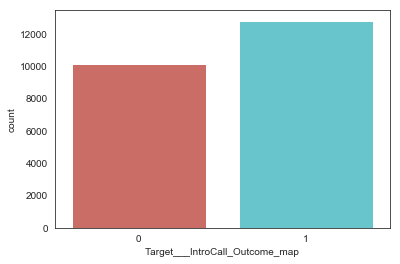

In [48]:
print("Qualfied (1) vs Disqualified Intro Calls (0)")
print("\n")
print(closedIntroCalls_Data.Target___IntroCall_Outcome_map.value_counts())
sns.countplot(x=closedIntroCalls_Data.Target___IntroCall_Outcome_map,data=closedIntroCalls_Data, palette='hls')
plt.show()

###  1B: Can you find trends (e.g. high, low, increasing, decreasing, anomalies)?


#### Data Exploration - Understanding Volumes of Qualified and DQ'd Intro Calls

Next I want to understand how the volume of intro calls has changed over time, both overall numbers and by qualification status (qualified vs disqualified).

The first graph below shows the volume of intro calls (min: ~ 0, high: ~50) versus their creation date (from Jan 2016 to Dec 2018). However the chart in its current state is difficult to discern for trends, so it might make sense to instead use a rolling mean.


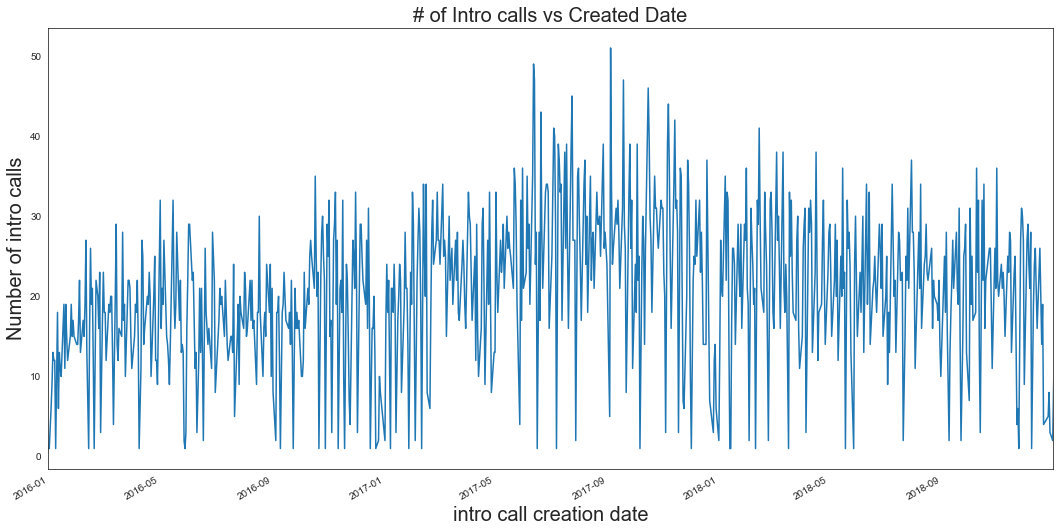

In [22]:
# Number of Intro Calls (both won and lost)

reportsOverTime = closedIntroCalls_Data.groupby('createddate___IntroCall_ImportantSystemInfo_clean')['createddate___IntroCall_ImportantSystemInfo_clean'].count()
fig = plt.figure(figsize=(18, 9))
reportsOverTime.plot()
plt.xlim([datetime.datetime(2016, 1, 1, 0, 0), datetime.datetime(2018, 12, 31, 0, 0)])
plt.ylabel('Number of intro calls', fontsize = 20)
plt.xlabel('intro call creation date', fontsize = 20)
plt.title('# of Intro calls vs Created Date', fontsize = 20)
plt.show()

The subsequent charts show the impact of taking a 7 day rolling average and then a 14 day rolling average. On inspection it seems like between May 2017 to Jan 2018 we had higher volumes of intro calls. 


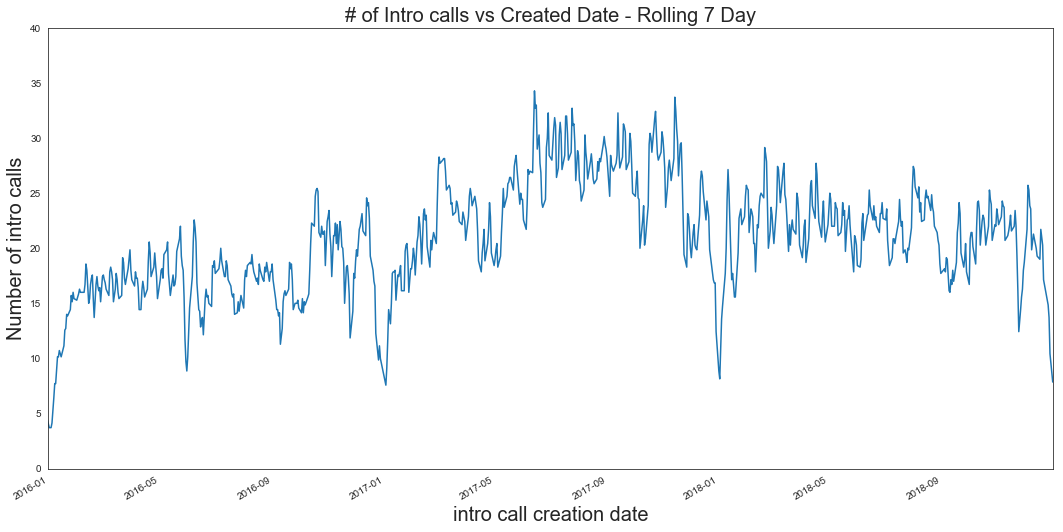

In [23]:
# Rolling 7 day avg 

reportsOverTime = closedIntroCalls_Data.groupby('createddate___IntroCall_ImportantSystemInfo_clean')['createddate___IntroCall_ImportantSystemInfo_clean'].count().rolling(7).mean()
fig = plt.figure(figsize=(18, 9))
reportsOverTime.plot()
plt.xlim([datetime.datetime(2016, 1, 1, 0, 0), datetime.datetime(2018, 12, 31, 0, 0)])
plt.ylim([0,40])
plt.ylabel('Number of intro calls', fontsize = 20)
plt.xlabel('intro call creation date', fontsize = 20)
plt.title('# of Intro calls vs Created Date - Rolling 7 Day', fontsize = 20)
plt.show()


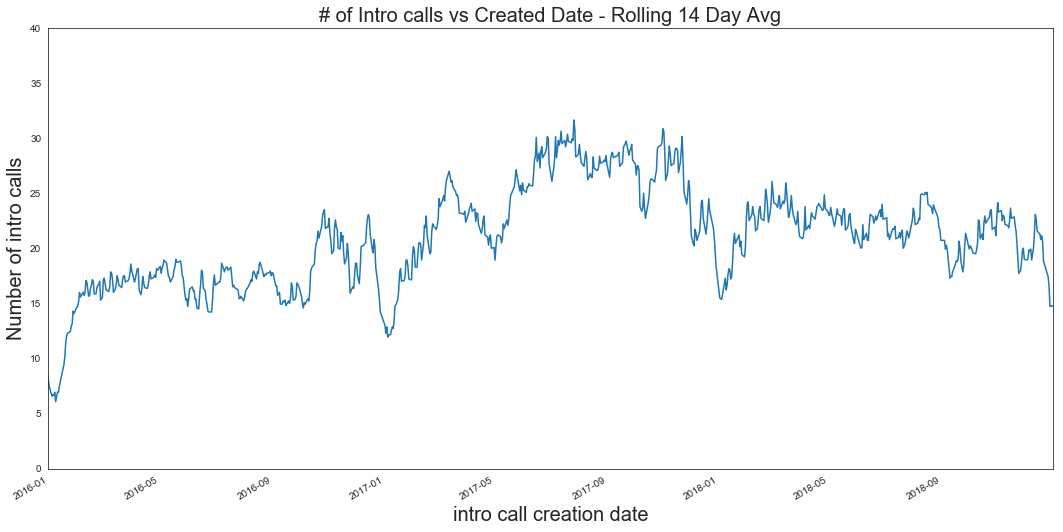

In [24]:
# Rolling 14 day avg 

reportsOverTime = closedIntroCalls_Data.groupby('createddate___IntroCall_ImportantSystemInfo_clean')['createddate___IntroCall_ImportantSystemInfo_clean'].count().rolling(14).mean()
fig = plt.figure(figsize=(18, 9))
reportsOverTime.plot()
plt.xlim([datetime.datetime(2016, 1, 1, 0, 0), datetime.datetime(2018, 12, 31, 0, 0)])
plt.ylim([0,40])
plt.ylabel('Number of intro calls', fontsize = 20)
plt.xlabel('intro call creation date', fontsize = 20)
plt.title('# of Intro calls vs Created Date - Rolling 14 Day Avg', fontsize = 20)
plt.show()

But what we’re really interested in is understanding the drivers of qualified calls, so it makes sense to view the volume by time and qualification status. 

<Figure size 432x288 with 0 Axes>

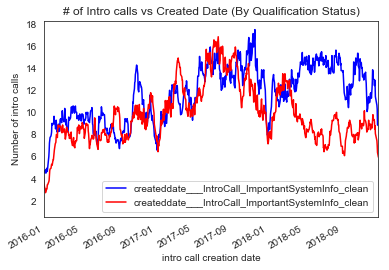

In [49]:
#'# of Intro calls vs Created Date (By Qualification Status)

qualifiedOverTime = closedIntroCalls_Data[closedIntroCalls_Data.Target___IntroCall_Outcome_map == 1].groupby('createddate___IntroCall_ImportantSystemInfo_clean')['createddate___IntroCall_ImportantSystemInfo_clean'].count().rolling(14).mean()
qualifiedOverTime = pd.DataFrame(qualifiedOverTime)

unqualifiedOverTime = closedIntroCalls_Data[closedIntroCalls_Data.Target___IntroCall_Outcome_map == 0].groupby('createddate___IntroCall_ImportantSystemInfo_clean')['createddate___IntroCall_ImportantSystemInfo_clean'].count().rolling(14).mean()
unqualifiedOverTime = pd.DataFrame(unqualifiedOverTime)


fig = plt.figure()
ax = qualifiedOverTime.plot(color='blue')
unqualifiedOverTime.plot(color='red',ax=ax)
plt.xlim([datetime.datetime(2016, 1, 1, 0, 0), datetime.datetime(2018, 12, 31, 0, 0)])

plt.ylabel('Number of intro calls')
plt.xlabel('intro call creation date')
plt.title('# of Intro calls vs Created Date (By Qualification Status)')
plt.show()

Red line is “unqualified”, blue line is “qualified”. It looks like volume has remained high in the last year but disqualifieds are making up a smaller proportion (possibly reinforcing the marketing team’s assertion that they’re providing higher quality leads).  


### 1C: Can you make a bar plot or a histogram?

#### Data Exploration - Understanding Demographics of Qualified and DQ'd Demos - Traffic Channel & Customer Type

Next I want to understand the sources of the intro calls (like marketing channels, landing pages, business type, etc).

Originally I tried a stacked barchart but it really only shows the volume of intro calls by landing page. The charts 'Top 30 Lead Marketing Channels by Qualified’ are sorted but the count of qualified intro calls per traffic channel. 

What’s interesting is that even though some marketing channels have produced a large volume of qualifieds, they aren’t necessarily the same channels responsible for producing a high ratio of qualifieds to disqualifieds. 

For example, lead source 3 & 0 (corresponding to “Brand” and “Affiliate”) have a ratio of 1.9 but are in sixth place and up, with additional intro call sources in between having a ratio of around 0.8~1.6.  This is the first time I’ve seen the marketing funnel from the perspective of the intro calls (even within the company) so it’s fascinating to see the different levels of quality.


   trafficChannel___Lead_MarketingInformation_map  notQ     Q  Ratio_QvNotQ
16                                        Unknown  1411  2424           1.7
13                                         Search  1477  2354           1.6
5                                Event/Conference  1061  1458           1.4
7                                        LinkedIn  1549  1383           0.9
10                                            PPC  1411  1279           0.9
6                                        Facebook  1184   929           0.8
3                                           Brand   297   550           1.9
18                                        Website   319   485           1.5
9                                        Outbound   217   338           1.6
15                                        Twitter   319   228           0.7
2                                            Blog   130   220           1.7
17                                           User   128   166           1.3
0           

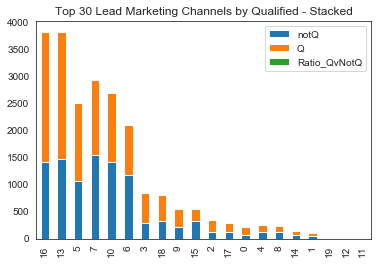

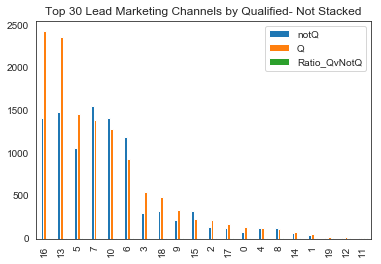

In [26]:
CA_requests = closedIntroCalls_Data.groupby(['trafficChannel___Lead_MarketingInformation_map','Target___IntroCall_Outcome_map'])['PK_IntroCall_ID___IntroCall_ImportantIDInfo'].count()
CA_requests = pd.DataFrame(CA_requests)
CA_requests.reset_index(inplace=True)

CA_requests.columns = ['trafficChannel___Lead_MarketingInformation_map','Target___IntroCall_Outcome_map', 'counts']
#print(CA_requests.head(5))

table = pd.pivot_table(CA_requests, values='counts', index='trafficChannel___Lead_MarketingInformation_map',columns=['Target___IntroCall_Outcome_map'], aggfunc=np.sum)
table = pd.DataFrame(table).fillna(0)
table.columns=['notQ','Q']
table.reset_index(inplace=True)
table['Ratio_QvNotQ'] = round(table['Q']/table['notQ'],1)

top30 = table.nlargest(30, 'Q')
print(top30)

top30.plot(kind='bar', stacked=True)
plt.ylabel('')
plt.xlabel('')
plt.title('Top 30 Lead Marketing Channels by Qualified - Stacked');
plt.show()

top30.plot(kind='bar', stacked=False);
plt.ylabel('');
plt.xlabel('');
plt.title('Top 30 Lead Marketing Channels by Qualified- Not Stacked');
plt.show()

The next question I was trying to answer was whether the customer type could be a driver of qualified intro calls. 

After generating the following charts, it seems that customer type could be a driver (as well as an indicator of the company’s strategic focus on the enterprise space). 

1 corresponds to ‘Enterprise’ (2 is ‘Unknown’, which doesn’t exactly bode the best in terms of our data quality) and 4 corresponds to ‘Nonprofits’ (which makes sense, the company primarily markets to companies willing to invest significant resources in onboarding and digital adoption). 


  customerType___Lead_LeadCompanyInformation  notQ     Q  Ratio_QvNotQ
1                                 Enterprise  3244  4894           1.5
6                                    Unknown  2379  3050           1.3
2                                 Mid Market  1976  2341           1.2
5                                    Startup  1852  1721           0.9
3                                 Non Profit   373   277           0.7
4                                    Partner    76    64           0.8
0                            Biz Dev Partner    52    41           0.8


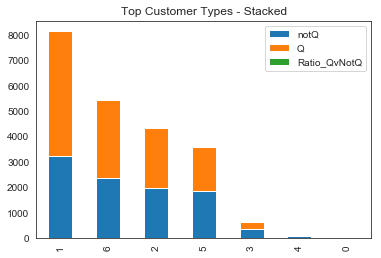

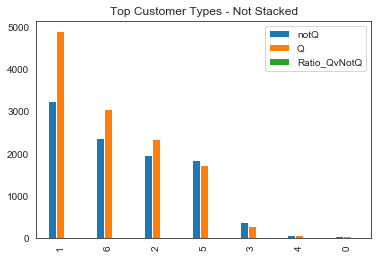

In [27]:
#Qualified and Unqualified calls by Customer Type

CA_requests = closedIntroCalls_Data.groupby(['customerType___Lead_LeadCompanyInformation','Target___IntroCall_Outcome_map'])['PK_IntroCall_ID___IntroCall_ImportantIDInfo'].count()
CA_requests = pd.DataFrame(CA_requests)
CA_requests.reset_index(inplace=True)

CA_requests.columns = ['customerType___Lead_LeadCompanyInformation','Target___IntroCall_Outcome_map', 'counts']
#print(CA_requests.head(5))

table = pd.pivot_table(CA_requests, values='counts', index='customerType___Lead_LeadCompanyInformation',columns=['Target___IntroCall_Outcome_map'], aggfunc=np.sum)
table = pd.DataFrame(table).fillna(0)
table.columns=['notQ','Q']
table.reset_index(inplace=True)
table['Ratio_QvNotQ'] = round(table['Q']/table['notQ'],1)

top30 = table.nlargest(30, 'Q')
print(top30)



top30.plot(kind='bar', stacked=True);
plt.ylabel('');
plt.xlabel('');
plt.title('Top Customer Types - Stacked');
plt.show()

top30.plot(kind='bar', stacked=False);
plt.ylabel('');
plt.xlabel('');
plt.title('Top Customer Types - Not Stacked');
plt.show()

Countries is a little surprising as we have some EMEA and ANZ/APAC countries listed as the top producers of qualified intro calls. The company started in Israel and has major presence in AMER but it’s interesting to see the UK (#111), Australia (#4), and Germany (#38) up in the top 8. 


    country___Lead_LeadCompanyInformation    notQ       Q  Ratio_QvNotQ
112                         United States  5512.0  7277.0           1.3
111                        United Kingdom   902.0  1017.0           1.1
16                                 Canada   573.0   654.0           1.1
4                               Australia   538.0   639.0           1.2
38                                Germany   220.0   290.0           1.3
50                                 Israel   192.0   215.0           1.1
36                                 France   124.0   211.0           1.7
72                            Netherlands   175.0   181.0           1.0
73                            New Zealand    84.0   111.0           1.3
101                           Switzerland    51.0   107.0           2.1
47                                  India   143.0   102.0           0.7
11                                Belgium    75.0    97.0           1.3
97                                  Spain    78.0    89.0       

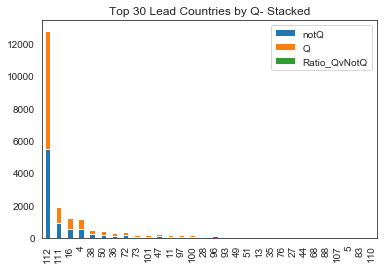

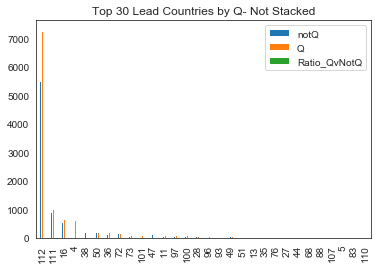

In [28]:
#Qualified and Unqualified calls by Country

CA_requests = closedIntroCalls_Data.groupby(['country___Lead_LeadCompanyInformation','Target___IntroCall_Outcome_map'])['PK_IntroCall_ID___IntroCall_ImportantIDInfo'].count()
CA_requests = pd.DataFrame(CA_requests)
CA_requests.reset_index(inplace=True)

CA_requests.columns = ['country___Lead_LeadCompanyInformation','Target___IntroCall_Outcome_map', 'counts']


table = pd.pivot_table(CA_requests, values='counts', index='country___Lead_LeadCompanyInformation',columns=['Target___IntroCall_Outcome_map'], aggfunc=np.sum)
table = pd.DataFrame(table).fillna(0)
table.columns=['notQ','Q']
table.reset_index(inplace=True)
table['Ratio_QvNotQ'] = round(table['Q']/table['notQ'],1)

top30 = table.nlargest(30, 'Q')
print(top30)

top30.plot(kind='bar', stacked=True);
plt.ylabel('');
plt.xlabel('');
plt.title('Top 30 Lead Countries by Q- Stacked');
plt.show()

top30.plot(kind='bar', stacked=False);
plt.ylabel('');
plt.xlabel('');
plt.title('Top 30 Lead Countries by Q- Not Stacked');
plt.show()

#### Data Exploration - Counts by Landing Page

When we look at landing pages and try to create top 30 charts, we see some interesting trends where the top 30 best landing pages by qualifieds count aren’t the same as the top 30 landing pages by ratio of qualified to disqualified intro calls. 

The first set of charts below show “Top 30 Landing Pages by Qualified Count”  and “Top 30 Landing Pages by Ratio (Qualified/Disqualified)”. Landing pages had to have more than 20 visitors in order to weed out cases where only 5 people visited a landing page and all converted (or none converted). Notice how the top 5 landing pages are completely different depending on the particular cut. 


In [29]:
#Top Landing Pages by Qualified and Unqualified
#1) Top 30 Landing Pages by Qualified Count

CA_requests = closedIntroCalls_Data.groupby(['landingPage___Lead_MarketingInformation','Target___IntroCall_Outcome_map'])['PK_IntroCall_ID___IntroCall_ImportantIDInfo'].count()
CA_requests = pd.DataFrame(CA_requests)
CA_requests.reset_index(inplace=True)

CA_requests.columns = ['landingPage___Lead_MarketingInformation','Target___IntroCall_Outcome_map', 'counts']


table = pd.pivot_table(CA_requests, values='counts', index='landingPage___Lead_MarketingInformation',columns=['Target___IntroCall_Outcome_map'], aggfunc=np.sum)
table = pd.DataFrame(table).fillna(0)
table.columns=['notQ','Q']
table.reset_index(inplace=True)
table['Ratio_QvNotQ'] = round(table['Q']/table['notQ'],1)


top30Q = table.nlargest(30, 'Q')
print("Top 30 Landing Pages by Qualified Count")
top30Q






Top 30 Landing Pages by Qualified Count


,landingPage___Lead_MarketingInformation,notQ,Q,Ratio_QvNotQ
267,home,85.0,152.0,1.8
771,using-salesforce,109.0,141.0,1.3
245,employee-training-easier-st2-2,191.0,125.0,0.7
129,creating-online-tutorials,112.0,77.0,0.7
336,instantly-improve-ux,104.0,77.0,0.7
484,salesforce-never-easier,83.0,62.0,0.7
26,Omri-SF2,18.0,53.0,2.9
379,never-been-easy,47.0,50.0,1.1
238,employee-training-easier,81.0,49.0,0.6
730,tutorial-creation,90.0,46.0,0.5


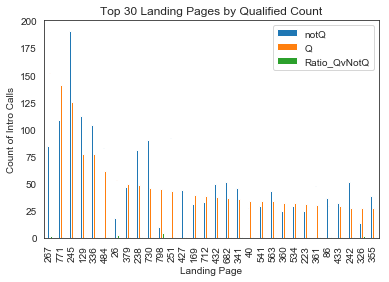

In [51]:
# Top 30 Landing Pages by Qualified Count

top30Q.plot(kind='bar', stacked=False);
plt.ylabel('Count of Intro Calls');
plt.xlabel('Landing Page');
plt.title('Top 30 Landing Pages by Qualified Count');
plt.show()

In [31]:
#2) Top 30 Landing Pages by Ratio of Qualified to Unqualified with more than 20 visitors


top30Q_byRatio = table[(table['notQ']+table['Q'])>20].replace(np.inf, np.nan).dropna().nlargest(30, 'Ratio_QvNotQ')
print("Top 30 Landing Pages by Ratio of Qualified to Unqualified with more than 20 visitors")
top30Q_byRatio

Top 30 Landing Pages by Ratio of Qualified to Unqualified with more than 20 visitors


,landingPage___Lead_MarketingInformation,notQ,Q,Ratio_QvNotQ
798,walkme,10.0,45.0,4.5
26,Omri-SF2,18.0,53.0,2.9
700,training-walkmeblog-corporate-002-b,8.0,20.0,2.5
474,salesforce-corporatevideo-3-sf-never-easier,10.0,22.0,2.2
326,improve-ux-2-wm,14.0,28.0,2.0
606,software-corporate-4-simplify-enterprise-software,11.0,22.0,2.0
119,concur-user-onboarding-1,8.0,15.0,1.9
274,http://www.walkme.com/,14.0,26.0,1.9
533,sf-s,12.0,23.0,1.9
267,home,85.0,152.0,1.8


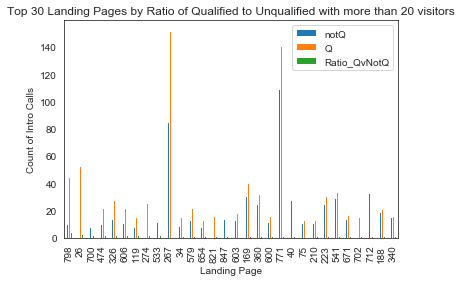

In [52]:
# Top 30 Landing Pages by Ratio of Qualified to Unqualified with more than 20 visitors

top30Q_byRatio.plot(kind='bar', stacked=False);
plt.ylabel('Count of Intro Calls');
plt.xlabel('Landing Page');
plt.title('Top 30 Landing Pages by Ratio of Qualified to Unqualified with more than 20 visitors');
plt.show()

This next set of charts focuses on landing page rankings of disqualified intro calls.


In [33]:
#3) Top 30 Landing Pages by DQ Count

top30DQ = table.nlargest(30, 'notQ')
print("Top 30 Landing Pages by Disqualified Count")
top30DQ

Top 30 Landing Pages by Disqualified Count


,landingPage___Lead_MarketingInformation,notQ,Q,Ratio_QvNotQ
245,employee-training-easier-st2-2,191.0,125.0,0.7
129,creating-online-tutorials,112.0,77.0,0.7
771,using-salesforce,109.0,141.0,1.3
336,instantly-improve-ux,104.0,77.0,0.7
251,employee-training-software,92.0,43.0,0.5
730,tutorial-creation,90.0,46.0,0.5
267,home,85.0,152.0,1.8
484,salesforce-never-easier,83.0,62.0,0.7
238,employee-training-easier,81.0,49.0,0.6
242,employee-training-easier-st1,52.0,28.0,0.5


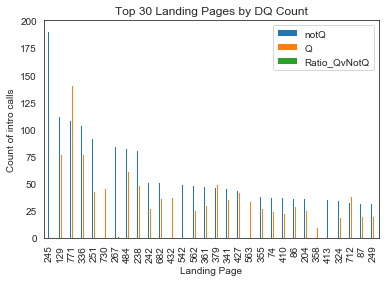

In [53]:
top30DQ.plot(kind='bar', stacked=False);
plt.ylabel('Count of intro calls');
plt.xlabel('Landing Page');
plt.title('Top 30 Landing Pages by DQ Count');
plt.show()

In [35]:
#2) Bottom 30 Landing Pages by Ratio of Qualified to Unqualified with more than 20 visitors


top30DQ_byRatio = table[(table['notQ']+table['Q'])>20].replace(np.inf, np.nan).dropna().nsmallest(30, 'Ratio_QvNotQ')
print("Bottom 30 Landing Pages by Ratio of Qualified to Unqualified with more than 20 visitors")
top30DQ_byRatio

Bottom 30 Landing Pages by Ratio of Qualified to Unqualified with more than 20 visitors


,landingPage___Lead_MarketingInformation,notQ,Q,Ratio_QvNotQ
38,SF-easier,18.0,6.0,0.3
221,elearning-solutions,18.0,6.0,0.3
358,make-tutorial-demo-tw,37.0,10.0,0.3
597,software-corporate-2-eliminate-frustration,16.0,5.0,0.3
195,dynamics-training-2-wm,21.0,8.0,0.4
201,effective,16.0,6.0,0.4
225,elearning-teach-wm,22.0,9.0,0.4
399,onboarding-corporate-1-new-hires-easier,17.0,7.0,0.4
530,servicenow-simplify-wm,16.0,6.0,0.4
542,sforce-never-been-easie,50.0,19.0,0.4


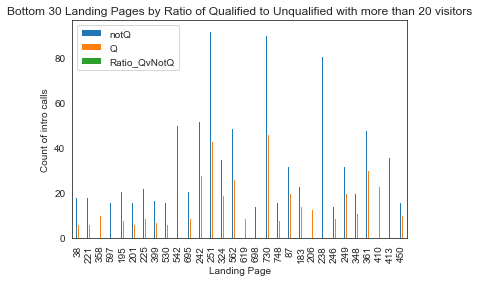

In [54]:
top30DQ_byRatio.plot(kind='bar', stacked=False);
plt.ylabel('Count of intro calls');
plt.xlabel('Landing Page');
plt.title('Bottom 30 Landing Pages by Ratio of Qualified to Unqualified with more than 20 visitors');
plt.show()

### 1E: Can you make a scatterplot?

Next I want to understand the relationship between the marketing stamped lead score and the total calls & emails logged against that lead. 

#### Data Exploration - Infer Score vs Total Calls & Emails

In [55]:

population = closedIntroCalls_Data.copy() 
population['totalCallsEmails'] = population['totalCalls___Lead_AddedInfo'] + population['totalEMails___Lead_AddedInfo'] 


CA_requests = population.groupby(['inferScore___Lead_AddedInfo','Target___IntroCall_Outcome_map'])['totalCallsEmails'].median()
CA_requests = pd.DataFrame(CA_requests)
CA_requests.reset_index(inplace=True)
CA_requests


,inferScore___Lead_AddedInfo,Target___IntroCall_Outcome_map,totalCallsEmails
0,6.0,0,NaN
1,7.0,0,19.5
2,8.0,0,15.0
3,9.0,0,11.0
4,9.0,1,19.0
5,11.0,0,9.0
6,11.0,1,12.0
7,12.0,0,NaN
8,12.0,1,9.0
9,13.0,0,NaN


Generating the charts below, it’s surprising to see that the greater the lead score, the more engagement is needed for that lead. 

After separating out the qualified and disqualified intro calls we notice there are some outliers (especially in the Qualifieds chart), where a lead score (of around 20) had +35 emails and calls logged. We don’t want to just address that one point, however, but a way to systematically address outliers. 

In [38]:
from scipy.stats import linregress

closedWonIntro = pd.DataFrame(CA_requests[CA_requests['Target___IntroCall_Outcome_map']>0])
closedWonIntro = closedWonIntro.replace(np.nan,0).dropna()

closedLostIntro = pd.DataFrame(CA_requests[CA_requests['Target___IntroCall_Outcome_map']<1])
closedLostIntro = closedLostIntro.replace(np.nan,0).dropna()

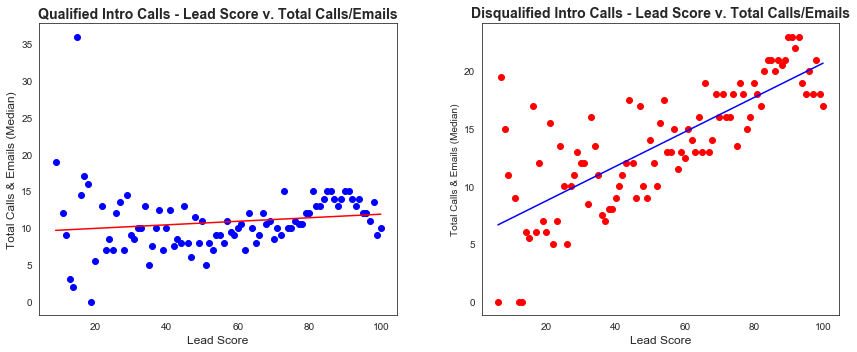

In [39]:
fig = plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
plt.plot(closedWonIntro.inferScore___Lead_AddedInfo, closedWonIntro.totalCallsEmails, 'bo');
plt.ylabel('Total Calls & Emails (Median)', fontsize = 12);
plt.xlabel('Lead Score', fontsize = 12);
plt.title('Qualified Intro Calls - Lead Score v. Total Calls/Emails', fontsize = 14, fontweight = 'bold');

#Add regression line
slope, intercept, r, p, stderr = linregress(closedWonIntro.inferScore___Lead_AddedInfo, closedWonIntro.totalCallsEmails)
line_values = [slope * i + intercept for i in list(closedWonIntro.inferScore___Lead_AddedInfo)]
plt.plot(list(closedWonIntro.inferScore___Lead_AddedInfo), line_values, '-r');


plt.subplot(1,3,2)
plt.plot(closedLostIntro.inferScore___Lead_AddedInfo, closedLostIntro.totalCallsEmails, 'ro');
plt.ylabel('Total Calls & Emails (Median)');
plt.xlabel('Lead Score', fontsize = 12);
plt.title('Disqualified Intro Calls - Lead Score v. Total Calls/Emails', fontsize = 14, fontweight = 'bold');

#Add regression line
slope2, intercept2, r2, p2, stderr2 = linregress(closedLostIntro.inferScore___Lead_AddedInfo, closedLostIntro.totalCallsEmails)
line_values2 = [slope2 * i + intercept2 for i in list(closedLostIntro.inferScore___Lead_AddedInfo)]
plt.plot(list(closedLostIntro.inferScore___Lead_AddedInfo), line_values2, '-b');
fig.tight_layout()

The following charts show outlier adjusted plots, where we can see a clearer relationship between qualified and disqualified intro calls. The trend is a bit more intuitive as we can imagine SDR’s and their workflows. 


For example, for qualified intro calls the relationship between total calls/emails and lead scores is less steep than for disqualified intro calls. In general the role of an SDR is to weed out the bad and keep hooked the good. For leads with higher lead scores, the positive slope could be showing that SDR’s will engage more with prospects they view as positive bets. 

With disqualified vs qualified intro calls it’s possible however that SDR’s could also be putting additional effort into “pulling people across the line” or setting calls with individuals that might not be a great fit and therefore need extra coaxing. 


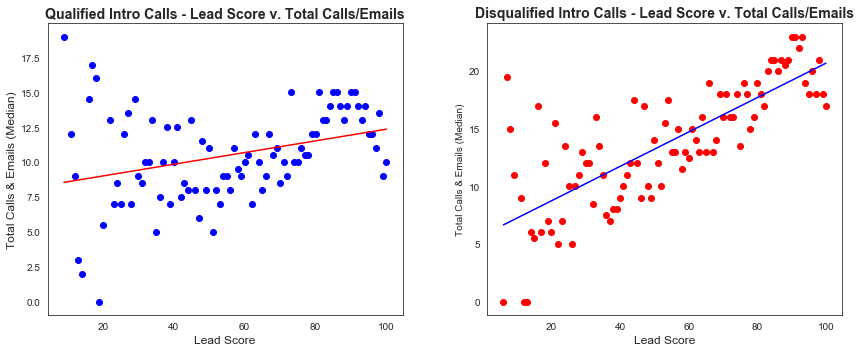

In [40]:
closedWonIntro = closedWonIntro[np.abs(closedWonIntro.totalCallsEmails-closedWonIntro.totalCallsEmails.mean()) <= (3*closedWonIntro.totalCallsEmails.std())]
closedLostIntro = closedLostIntro[np.abs(closedLostIntro.totalCallsEmails-closedLostIntro.totalCallsEmails.mean()) <= (3*closedLostIntro.totalCallsEmails.std())]


fig = plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
plt.plot(closedWonIntro.inferScore___Lead_AddedInfo, closedWonIntro.totalCallsEmails, 'bo');
plt.ylabel('Total Calls & Emails (Median)', fontsize = 12);
plt.xlabel('Lead Score', fontsize = 12);
plt.title('Qualified Intro Calls - Lead Score v. Total Calls/Emails', fontsize = 14, fontweight = 'bold');

#Add regression line
slope, intercept, r, p, stderr = linregress(closedWonIntro.inferScore___Lead_AddedInfo, closedWonIntro.totalCallsEmails)
line_values = [slope * i + intercept for i in list(closedWonIntro.inferScore___Lead_AddedInfo)]
plt.plot(list(closedWonIntro.inferScore___Lead_AddedInfo), line_values, '-r');


plt.subplot(1,3,2)
plt.plot(closedLostIntro.inferScore___Lead_AddedInfo, closedLostIntro.totalCallsEmails, 'ro');
plt.ylabel('Total Calls & Emails (Median)');
plt.xlabel('Lead Score', fontsize = 12);
plt.title('Disqualified Intro Calls - Lead Score v. Total Calls/Emails', fontsize = 14, fontweight = 'bold');

#Add regression line
slope2, intercept2, r2, p2, stderr2 = linregress(closedLostIntro.inferScore___Lead_AddedInfo, closedLostIntro.totalCallsEmails)
line_values2 = [slope2 * i + intercept2 for i in list(closedLostIntro.inferScore___Lead_AddedInfo)]
plt.plot(list(closedLostIntro.inferScore___Lead_AddedInfo), line_values2, '-b');
fig.tight_layout()

#### Data Exploration - Intro Call Created Delta vs Total Calls & Emails

In trying to analyze the relationship between “introCallCreated_leadCreated_delta” (days elapsed between when the lead was created and when the intro call was created i.e. when a lead hit our system and someone talked to them)  and total calls/emails there seems to be a negative relationship. 

Top row of charts includes outliers, bottom row excludes outliers. 


In [57]:

users_population = closedIntroCalls_Data.copy() 
users_population['totalCallsEmails'] = users_population['totalCalls___Lead_AddedInfo'] + users_population['totalEMails___Lead_AddedInfo'] 


CA_requests = users_population.groupby(['introCallCreated_leadCreated_delta','Target___IntroCall_Outcome_map'])['totalCallsEmails'].mean()
CA_requests = pd.DataFrame(CA_requests)
CA_requests.reset_index(inplace=True)
CA_requests


,introCallCreated_leadCreated_delta,Target___IntroCall_Outcome_map,totalCallsEmails
0,-569.0,1,1.000000
1,-83.0,1,NaN
2,-19.0,1,NaN
3,-14.0,1,NaN
4,-10.0,1,NaN
5,-6.0,1,1.000000
6,0.0,0,15.906282
7,0.0,1,10.022328
8,1.0,0,19.582063
9,1.0,1,12.404762


In [42]:
from scipy.stats import linregress

closedWonIntro = pd.DataFrame(CA_requests[CA_requests['Target___IntroCall_Outcome_map']>0])
closedWonIntro = closedWonIntro.replace(np.nan,0).dropna()

closedLostIntro = pd.DataFrame(CA_requests[CA_requests['Target___IntroCall_Outcome_map']<1])
closedLostIntro = closedLostIntro.replace(np.nan,0).dropna()

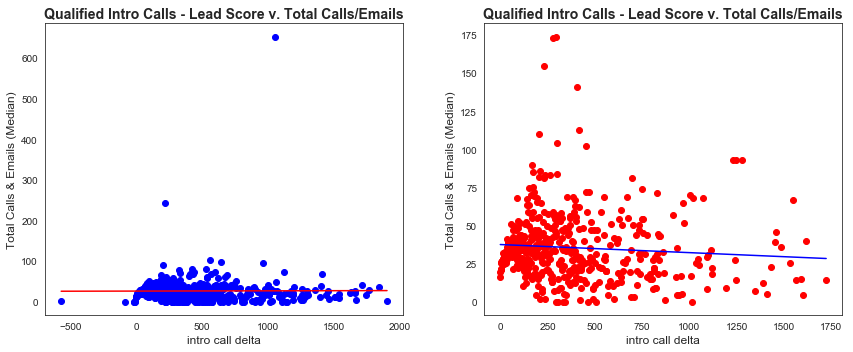

In [43]:
fig = plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
plt.plot(closedWonIntro.introCallCreated_leadCreated_delta, closedWonIntro.totalCallsEmails, 'bo');
plt.ylabel('Total Calls & Emails (Median)', fontsize = 12);
plt.xlabel('intro call delta', fontsize = 12);
plt.title('Qualified Intro Calls - Lead Score v. Total Calls/Emails', fontsize = 14, fontweight = 'bold');

#Add regression line
slope, intercept, r, p, stderr = linregress(closedWonIntro.introCallCreated_leadCreated_delta, closedWonIntro.totalCallsEmails)
line_values = [slope * i + intercept for i in list(closedWonIntro.introCallCreated_leadCreated_delta)]
plt.plot(list(closedWonIntro.introCallCreated_leadCreated_delta), line_values, '-r');


plt.subplot(1,3,2)
plt.plot(closedLostIntro.introCallCreated_leadCreated_delta, closedLostIntro.totalCallsEmails, 'ro');
plt.ylabel('Total Calls & Emails (Median)', fontsize = 12);
plt.xlabel('intro call delta', fontsize = 12);
plt.title('Qualified Intro Calls - Lead Score v. Total Calls/Emails', fontsize = 14, fontweight = 'bold');

#Add regression line
slope2, intercept2, r2, p2, stderr2 = linregress(closedLostIntro.introCallCreated_leadCreated_delta, closedLostIntro.totalCallsEmails)
line_values2 = [slope2 * i + intercept2 for i in list(closedLostIntro.introCallCreated_leadCreated_delta)]
plt.plot(list(closedLostIntro.introCallCreated_leadCreated_delta), line_values2, '-b');
fig.tight_layout()

However given how similar the trend is between qualified and disqualified intro calls I’m not sure there is a meaningful relationship we can analyze.

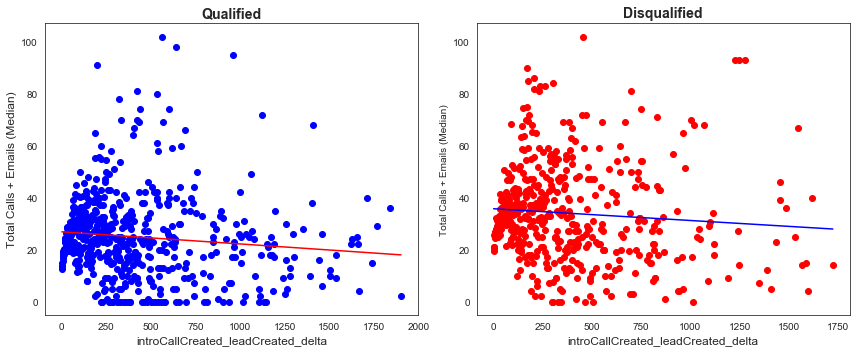

In [44]:
closedWonIntro = closedWonIntro[np.abs(closedWonIntro.totalCallsEmails-closedWonIntro.totalCallsEmails.mean()) <= (3*closedWonIntro.totalCallsEmails.std())]
closedWonIntro = closedWonIntro[closedWonIntro['introCallCreated_leadCreated_delta']>0]

closedLostIntro = closedLostIntro[np.abs(closedLostIntro.totalCallsEmails-closedLostIntro.totalCallsEmails.mean()) <= (3*closedLostIntro.totalCallsEmails.std())]
closedLostIntro = closedLostIntro[closedLostIntro['introCallCreated_leadCreated_delta']>0]

fig = plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
plt.plot(closedWonIntro.introCallCreated_leadCreated_delta, closedWonIntro.totalCallsEmails, 'bo');
plt.ylabel('Total Calls + Emails (Median)', fontsize = 12);
plt.xlabel('introCallCreated_leadCreated_delta', fontsize = 12);
plt.title('Qualified', fontsize = 14, fontweight = 'bold');

#Add regression line
slope, intercept, r, p, stderr = linregress(closedWonIntro.introCallCreated_leadCreated_delta, closedWonIntro.totalCallsEmails)
line_values = [slope * i + intercept for i in list(closedWonIntro.introCallCreated_leadCreated_delta)]
plt.plot(list(closedWonIntro.introCallCreated_leadCreated_delta), line_values, '-r');


plt.subplot(1,3,2)
plt.plot(closedLostIntro.introCallCreated_leadCreated_delta, closedLostIntro.totalCallsEmails, 'ro');
plt.ylabel('Total Calls + Emails (Median)');
plt.xlabel('introCallCreated_leadCreated_delta', fontsize = 12);
plt.title('Disqualified', fontsize = 14, fontweight = 'bold');

#Add regression line
slope2, intercept2, r2, p2, stderr2 = linregress(closedLostIntro.introCallCreated_leadCreated_delta, closedLostIntro.totalCallsEmails)
line_values2 = [slope2 * i + intercept2 for i in list(closedLostIntro.introCallCreated_leadCreated_delta)]
plt.plot(list(closedLostIntro.introCallCreated_leadCreated_delta), line_values2, '-b');
fig.tight_layout()

### 2: Looking at the plots, what are some insights you can make? Do you see any correlations? Is there a hypothesis you’d like to investigate further? What other questions do the insights lead you to ask?

I’d like to further investigate the following variables as potential candidates for drivers of intro call status:

* Landing Page 
* Lead/Marketing Channel
* Customer Type
* Creation Date


I’m ambivalent about the following variables given the mixed results I’ve seen in the previous charts:

* Lead Score
* Intro Call - Lead Creation Delta
* Region

I’m interested in seeing which of these variables end up being major contributors to the predictive models I’ll be generating. Within the company we have a lot of untested beliefs about what drives a successful sales and being able to test out some of these assumptions will be incredibly helpful. 

One belief we have internally that can’t be tested directly (but could be indirectly) is that different sales teams have drastically different close rates. The difficulty in trying to test that question is the company has completely restructured the sales teams in the last 4-6 years and we don’t have historical data on which individuals were on which teams handling specific deals. For the most part teams have been split across geographic territories so one way to determine if some teams (or regions) were more effective is analyzing the impact of geography on the qualification rates.  

Another belief we have is that lead with higher lead scores should perform better and require less handholding.
 
### 3: Now that you’ve asked questions, hopefully you’ve found some interesting insights. Is there a narrative or a way of presenting the insights using text and plots that tells a compelling story? What are some other trends/relationships you think will make the story more complete?

Product details could be important in determining whether an intro call has been qualified. The company has marketed towards specific enterprise platforms and products (like SAP, Salesforce, etc) and we’ve had better luck in supporting some platforms as opposed to others. 

Product information is captured in a picklist (which then becomes a nested string in the data warehouse) so it’ll take some additional cleaning to analyze the relationship between product of interest and qualification. 

